# **Problem Statement**

## Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).

## Objective

“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description

The data provided is a transformed version of the original data which was collected using sensors.

- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.

Both the datasets consist of 40 predictor variables and 1 target variable.

# **Installing and Importing the necessary libraries**

In [1]:
# Installing the libraries with the specified version
# !pip install --no-deps tensorflow==2.18.0 scikit-learn==1.3.2 matplotlib===3.8.3 seaborn==0.13.2 numpy==1.26.4 pandas==2.2.2 -q --user --no-warn-script-location

!pip install tensorflow scikit-learn matplotlib seaborn numpy pandas --user

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import time

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Imports tools for data preprocessing including label encoding, one-hot encoding, and standard scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
#Imports a class for imputing missing values in datasets.
from sklearn.impute import SimpleImputer

import tensorflow as tf #An end-to-end open source machine learning platform
from tensorflow import keras  # High-level neural networks API for deep learning.
from keras import backend   # Abstraction layer for neural network backend engines.
from keras.models import Sequential  # Model for building NN sequentially.
from keras.layers import (
    Dense,
    Dropout,
    Activation,
    BatchNormalization  # Layers for building NN.
)

# Libraries to get different metric scores
from sklearn import metrics
from sklearn.utils import class_weight

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")


2025-08-04 01:40:52.210207: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Global Data Values**

In [2]:
# Random state for reproducibility
RS = 42

# Validation size for train-validation split
VS = 0.25

# Scoring function for model evaluation. Note to please see above section Important Information About Work Visas for a explanation on why I am choosing recall as the scoring metric.
SCORER = metrics.make_scorer(metrics.recall_score)

# Set class weights as imbalanced data is used
CLASS_WEIGHTS = {0:1.0, 1: 10.0}

EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE=0.001
THRESHOLD = 0.5

### Common Methods

* To save and reduce code duplication I'm predefining methods that will be used frequently through the EDA and Data Modeling steps. The methods will cover:
    * Confusion Matrix Rendering
    * Correlation Matrix Rendering
    * Box Plot and Histogram Rendering
    * Scatter Plot and Count Plot Rendering

In [3]:
# Function to plot the confusion matrix
# Parameters:
# model: The trained model to evaluate.
# x: Features used for prediction.
# y: True labels for the features.
# title: Optional title for the confusion matrix plot.
def draw_confusion_matrix(model, x, y, title=None):
    y_pred = model.predict(x) > THRESHOLD  # Predict probabilities and convert to binary predictions based on the threshold

    cm = confusion_matrix(y, y_pred, labels=[0, 1])

    # Normalize by row (example)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create labels for each cell in the confusion matrix with both count and percentage
    labels = np.asarray(
        [
            f"{item}\n{item / cm.sum():.2%}"
            for item in cm.flatten()
        ]
    ).reshape(cm.shape)

    # Create the confusion matrix display and turn off the grid
    # and set the display labels to 'No' and 'Yes'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(include_values=False)  # Prevent default annotation

    ax = disp.ax_

    # Set the title of the confusion matrix plot if provided
    if title is not None:
        ax.set_title(title)

    for (i, j), label in np.ndenumerate(labels):
        ax.text(j, i, label, ha='center', va='center', color='black', fontsize=12)
    plt.grid(False)  # Turn off the grid

def highlight_strong_correlations(val):
    color = ''
    if abs(val) >= THRESHOLD and abs(val) < 1:  # Exclude self-correlation of 1
        color = 'background-color: green'

    return color

def draw_default_correlation_matrix(data):

    """
    Plot the correlation matrix for the given DataFrame.

    Parameters:
    data (DataFrame): The DataFrame containing the data.
    """

    cols_list = data.select_dtypes(include=np.number).columns.tolist()

    # Calculate the correlation matrix
    correlation_matrix = data[cols_list].corr()

    styled_corr = correlation_matrix.style.applymap(highlight_strong_correlations)
    display(styled_corr)

    # Plot the correlation matrix using a heatmap
    plt.figure(figsize=(64, 32))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix')
    plt.show()

#Method to draw box plot and histogram for univariate analysis
# Parameters:
# data: The DataFrame containing the data.
# column_name: The name of the column for which the box plot and histogram will be drawn.
def draw_boxplot_and_histogram(data, column_name):
    plt.figure(figsize=(18, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[column_name], bins=30, kde=True)
    plt.title(f'{column_name} Distribution')
    
    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column_name])
    plt.title(f'{column_name} Box Plot')
    
    plt.show()

**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

# **Loading the Data**

In [4]:
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

#Make a copy of the train and test data
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()


# **Data Overview**

In [5]:
# Check that the percentage of the output variable is the same in both train and test datasets
train_percentage = train_data['Target'].value_counts(normalize=True)
test_percentage = test_data['Target'].value_counts(normalize=True)

print("Train Data Output Percentage:\n\n", train_percentage)
print("Test Data Output Percentage:\n", test_percentage)

Train Data Output Percentage:

 Target
0    0.9445
1    0.0555
Name: proportion, dtype: float64
Test Data Output Percentage:
 Target
0    0.9436
1    0.0564
Name: proportion, dtype: float64


* As a quick sanity check we can see that the percentage of the Target variable false to true ratios as approximately 95% false, to 5% true in both the Training data set and test data set which is good. This means that the test data is representative of the correct population ratio.
* The challenging thing, however, with this data set is that it is heavily unbalanced which means that there isn't a lot of failure data included in the dataset for both the training and test sets. We will want to use the class_weight option where we can give more weight to the minority output class value of 1, which indicates a wind turbine failure.
* The data set has a binary classification of either 0 no failure, or 1 for failure for the wind turbine. This means we can use Sigmoid for output layer since it is best at binary classification which this problem set aligns with.

In [6]:
train_data_copy.head(10)  # Display the first 10 rows of the training data copy

V1        V2        V3        V4        V5        V6        V7  \
0 -4.464606 -4.679129  3.101546  0.506130 -0.221083 -2.032511 -2.910870   
1  3.365912  3.653381  0.909671 -1.367528  0.332016  2.358938  0.732600   
2 -3.831843 -5.824444  0.634031 -2.418815 -1.773827  1.016824 -2.098941   
3  1.618098  1.888342  7.046143 -1.147285  0.083080 -1.529780  0.207309   
4 -0.111440  3.872488 -3.758361 -2.982897  3.792714  0.544960  0.205433   
5  0.159623 -4.233781 -0.264310 -5.477119 -0.190854 -0.356274 -0.134486   
6 -0.184565 -4.721470  0.864988 -3.078695 -2.226888 -1.282220 -0.804717   
7  1.734840  1.682945 -1.269070  4.600630 -1.416975 -2.543916  0.131648   
8  1.781583  1.314664  4.248690 -0.518293 -0.149044  0.033082 -1.087893   
9 -0.894140  4.011498  5.251902  3.320747  0.727067 -4.771070  1.031232   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.050714 -1.522351  3.761892 -5.714719  0.735893  0.981251  1.417884   
1 -4.332135  0.565695 -0.101080  1.914465 -0.951458 -1.255259 -2.706522   
2 -3.173204 -2.081860  5.392621 -0.770673  1.106718  1.144261  0.943301   
3 -2.493629  0.344926  2.118578 -3.053023  0.459719  2.704527 -0.636086   
4  4.848994 -1.854920 -6.220023  1.998347  4.723757  0.709113 -1.989432   
5  4.066608 -3.858569  1.692441  0.137901  3.974719  0.672853  1.878144   
6  3.289733 -1.567971  0.749904  0.528830  3.220564  2.945183  1.724073   
7 -0.198661  3.094057 -1.109324 -1.662364  0.943806  3.481045  0.137055   
8 -3.117561  0.624935  1.567455 -0.415122 -1.400792  2.607063 -1.023519   
9  3.632080 -1.391444 -1.966746 -4.779273  6.616781 -0.147815 -2.513234   

        V15       V16       V17       V18       V19       V20       V21  \
0 -3.375815 -3.047303  0.306194  2.914097  2.269979  4.394876 -2.388299   
1  0.193223 -4.769379 -2.205319  0.907716  0.756894 -5.833678 -3.065122   
2 -3.163804 -4.247825 -4.038909  3.688534  3.311196  1.059002 -2.143026   
3 -0.453717 -3.174046 -3.404347 -1.281536  1.582104 -1.951778 -3.516555   
4 -2.632684  4.184447  2.245356  3.734452 -6.312766 -5.379918 -0.886667   
5  0.764158  4.235913 -2.129272  2.348465 -2.147454 -0.982376  0.386345   
6 -0.923123  2.534830 -1.696713  0.677068 -0.246087  2.747678 -1.165392   
7 -3.472977 -4.075917  1.726571 -1.908618  3.569249  2.512191 -4.578679   
8 -2.877902 -4.524080 -4.353952  0.106859  1.298601 -3.595654 -5.409204   
9  0.734111  0.474710  5.085254 -2.360998  4.561398  2.287065 -2.307024   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.646388 -1.190508  3.132986  0.665277 -2.510846 -0.036744  0.726218   
1  1.596647 -1.757311  1.766444 -0.267098  3.625036  1.500346 -0.585712   
2  1.650120 -1.660592  1.679910 -0.450782 -4.550695  3.738779  1.134404   
3 -1.206011 -5.627854 -1.817653  2.124142  5.294642  4.748137 -2.308536   
4  2.061694  9.445586  4.489976 -3.945144  4.582065 -8.780422 -3.382967   
5  1.010637  3.418654  0.996017  0.060580 -3.036740  1.787573 -1.726537   
6  0.247621  1.160684 -2.850139  0.503405 -3.532215  1.861243 -1.465354   
7  3.062674  3.686149  0.610743 -0.429539  0.880126 -0.993851  1.134221   
8  0.633421 -3.043436  0.965268 -0.266332  4.670862  1.846717 -2.320822   
9 -0.948690 -0.300906  2.546197  0.738320  4.266330 -4.144926 -0.012559   

        V29       V30       V31       V32       V33        V34       V35  \
0 -3.982187 -1.072638  1.667098  3.059700 -1.690440   2.846296  2.235198   
1  0.783034 -0.201217  0.024883 -1.795474  3.032780  -2.467514  1.894599   
2 -2.033531  0.840839 -1.600395 -0.257101  0.803550   4.086219  2.292138   
3 -3.962977 -6.028730  4.948770 -3.584425 -2.577474   1.363769  0.622714   
4  5.106507  6.787513  2.044184  8.265896  6.629213 -10.068689  1.222987   
5  0.307837  1.902350  4.665858  3.227235  0.628900  -1.548860  1.321979   
6  0.873767  2.418470  0.939376 -0.544941 -0.762921   0.815558  1.889373   
7 -3.767917 -0.692236 -5.244396  1.717474 -3.838931   1.569448  1.794899   
8 -1.317705 -0.681722

In [7]:
test_data_copy.head(10)


V1        V2        V3        V4        V5        V6        V7  \
0 -0.613489 -3.819640  2.202302  1.300420 -1.184929 -4.495964 -1.835817   
1  0.389608 -0.512341  0.527053 -2.576776 -1.016766  2.235112 -0.441301   
2 -0.874861 -0.640632  4.084202 -1.590454  0.525855 -1.957592 -0.695367   
3  0.238384  1.458607  4.014528  2.534478  1.196987 -3.117330 -0.924035   
4  5.828225  2.768260 -1.234530  2.809264 -1.641648 -1.406698  0.568643   
5 -1.885713 -1.964160  0.245667 -1.187255  0.027369 -2.214094 -0.605558   
6 -1.836429  1.216661 -0.186460  0.232731  1.752135 -1.982141  0.637039   
7 -1.649117  0.646787  2.657947  1.395099  0.725959  0.305211 -1.877257   
8 -2.744431 -5.870927  1.169155 -1.586454 -2.215360 -3.561773 -2.037385   
9 -0.247320 -1.130009  4.584899  0.051528  0.044828 -2.527062 -1.643095   

         V8        V9       V10       V11       V12       V13       V14  \
0  4.722989  1.206140 -0.341909 -5.122874  1.017021  4.818549  3.269001   
1 -4.405744 -0.332869  1.966794  1.796544  0.410490  0.638328 -1.389600   
2  1.347309 -1.732348  0.466500 -4.928214  3.565070 -0.449329 -0.656246   
3  0.269493  1.322436  0.702345 -5.578345 -0.850662  2.590525  0.767418   
4  0.965043  1.918379 -2.774855 -0.530016  1.374544 -0.650941 -1.679466   
5  3.434368 -2.366542  0.238592 -2.421572  5.443762  1.621775  0.403306   
6  3.654029 -2.891643 -0.882726 -2.881859  5.532344 -1.843551 -0.994694   
7 -3.814487  2.273639  0.434063 -2.533155 -3.581302  1.480436 -0.453753   
8  2.782849 -0.687223  1.527678 -4.668574  5.722978  5.746367  2.352832   
9  1.042020 -0.059002  0.751700 -4.915543  0.709726  1.810841  0.466331   

        V15       V16       V17       V18       V19       V20       V21  \
0 -2.984330  1.387370  2.032002 -0.511587 -1.023069  7.338733 -2.242244   
1 -1.883410 -5.017922 -3.827238  2.418060  1.762285 -3.242297 -3.192960   
2 -0.166537 -1.630207  2.291865  2.396492  0.601278  1.793534 -2.120238   
3 -2.390809 -2.341961  0.571875 -0.933751  0.508677  1.210715 -3.259524   
4 -0.379220 -4.443143  3.893857 -0.607640  2.944931  0.367233 -5.789081   
5 -2.084618  0.838689  1.168480  2.018892  0.968280  1.563233 -2.037208   
6  0.602109  1.870065  3.930774  1.278002  1.110149  0.088251  0.226533   
7 -3.334392 -4.882117 -0.657244  1.311949 -0.487993  0.744801 -2.215417   
8 -5.336724 -2.039904  0.340710  3.045392  1.603427  6.519083 -4.491886   
9 -2.012662 -2.139615  0.767581  1.047640  0.299762  2.506561 -3.523522   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.155489  2.053786 -2.772273  1.851369 -1.788696 -0.277282 -1.255143   
1  1.857454 -1.707954  0.633444 -0.587898  0.083683  3.013935 -0.182309   
2  0.481968 -0.840707  1.790197  1.874395  0.363930 -0.169063 -0.483832   
3  0.104587 -0.658875  1.498107  1.100305  4.142988 -0.248446 -1.136516   
4  4.597528  4.450264  3.224941  0.396701  0.247765 -2.362047  1.079378   
5  1.807605  4.216895  2.806480 -0.692462 -1.224669 -1.904662 -0.416139   
6  1.064542  4.210596  5.268233 -0.754587  0.433090 -4.173879  0.675818   
7 -0.555530 -3.758861 -0.623616  0.436324  2.663326  0.024642 -0.514574   
8  2.848353  3.717535 -1.080943  0.840454 -4.229435  1.391155 -0.403130   
9  0.229476 -1.363760  0.667588  1.640188  1.301918  0.040996 -1.302753   

        V29       V30       V31       V32       V33       V34       V35  \
0 -3.832886 -1.504542  1.586765  2.291204 -5.411388  0.870073  0.574479   
1  0.223917  0.865228 -1.782158 -2.474936  2.493582  0.315165  2.059288   
2 -2.118982 -2.156586  2.907291 -1.318888 -2.997464  0.459664  0.619774   
3 -5.355810 -4.545931  3.808667  3.517918 -3.074085 -0.284220  0.954576   
4 -0.473076  2.242810 -3.591421  1.773841 -1.501573 -2.226702  4.776830   
5 -1.203544  1.657175  0.658367  3.481445 -1.241937  0.165481  1.938014   
6 -0.654066  0.612422  1.253968  3.697508 -1.371313 -0.267922  0.385374   
7 -1.836844 -2.277864 -0.105820 -1.082314  0.530939 -0.290736 -0.219059   
8 -4.380458 -0.042646 -2.19262

In [8]:
#Check the initial shape of the train and test data
print("Train Data Shape:", train_data_copy.shape)
print("Test Data Shape:", test_data_copy.shape)

Train Data Shape: (20000, 41)
Test Data Shape: (5000, 41)


In [9]:
#Print the info of the train and test data
print("Train Data Info:")
train_data_copy.info()

print("\nTest Data Info:")
test_data_copy.info()

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-

* The 40 input parameters V1-V40 are all floating point values
* The 1 output parameter Target is an integer

In [10]:
#Check for missing values in the train and test data
print("\nMissing Values in Train Data:\n", train_data_copy.isnull().sum())
print("\nMissing Values in Test Data:\n", test_data_copy.isnull().sum())

#Print the total number of missing values in the train and test data
print("\nTotal Missing Values in Train Data:", train_data_copy.isnull().sum().sum())
print("Total Missing Values in Test Data:", test_data_copy.isnull().sum().sum())


Missing Values in Train Data:
 V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

Missing Values in Test Data:
 V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33    

* There are a total of 36 missing values in the training data set.
* There are  total of 11 missing values in the test data set.
* Since we need to avoid data leaking we have to split the training set into training and validation sets and then apply the data treatment on training, validation, and test sets separately.


* After splitting the training data into training and validation sets we confirm that proportion of 0 to 1 is 95% to 5% respectively.

In [11]:
#Check for duplicate rows in the training data
duplicates_train = train_data_copy.duplicated().sum()
print("\nDuplicate Rows in Train Data:", duplicates_train)


Duplicate Rows in Train Data: 0


In [12]:
# Look at the description of the training data
train_data_copy.describe()

V1            V2            V3            V4            V5  \
count  19982.000000  19982.000000  20000.000000  20000.000000  20000.000000   
mean      -0.271996      0.440430      2.484699     -0.083152     -0.053752   
std        3.441625      3.150784      3.388963      3.431595      2.104801   
min      -11.876451    -12.319951    -10.708139    -15.082052     -8.603361   
25%       -2.737146     -1.640674      0.206860     -2.347660     -1.535607   
50%       -0.747917      0.471536      2.255786     -0.135241     -0.101952   
75%        1.840112      2.543967      4.566165      2.130615      1.340480   
max       15.493002     13.089269     17.090919     13.236381      8.133797   

                 V6            V7            V8            V9           V10  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      -0.995443     -0.879325     -0.548195     -0.016808     -0.012998   
std        2.040970      1.761626      3.295756      2.160568      2.193201   
min      -10.227147     -7.949681    -15.657561     -8.596313     -9.853957   
25%       -2.347238     -2.030926     -2.642665     -1.494973     -1.411212   
50%       -1.000515     -0.917179     -0.389085     -0.067597      0.100973   
75%        0.380330      0.223695      1.722965      1.409203      1.477045   
max        6.975847      8.006091     11.679495      8.137580      8.108472   

                V11           V12           V13           V14           V15  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      -1.895393      1.604825      1.580486     -0.950632     -2.414993   
std        3.124322      2.930454      2.874658      1.789651      3.354974   
min      -14.832058    -12.948007    -13.228247     -7.738593    -16.416606   
25%       -3.922404     -0.396514     -0.223545     -2.170741     -4.415322   
50%       -1.921237      1.507841      1.637185     -0.957163     -2.382617   
75%        0.118906      3.571454      3.459886      0.270677     -0.359052   
max       11.826433     15.080698     15.419616      5.670664     12.246455   

                V16           V17           V18           V19           V20  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      -2.925225     -0.134261      1.189347      1.181808      0.023608   
std        4.221717      3.345462      2.592276      3.396925      3.669477   
min      -20.374158    -14.091184    -11.643994    -13.491784    -13.922659   
25%       -5.634240     -2.215611     -0.403917     -1.050168     -2.432953   
50%       -2.682705     -0.014580      0.883398      1.279061      0.033415   
75%       -0.095046      2.068751      2.571770      3.493299      2.512372   
max       13.583212     16.756432     13.179863     13.237742     16.052339   

                V21           V22           V23           V24           V25  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      -3.611252      0.951835     -0.366116      1.134389     -0.002186   
std        3.567690      1.651547      4.031860      3.912069      2.016740   
min      -17.956231    -10.122095    -14.866128    -16.387147     -8.228266   
25%       -5.930360     -0.118127     -3.098756     -1.468062     -1.365178   
50%       -3.532888      0.974687     -0.262093      0.969048      0.025050   
75%       -1.265884      2.025594      2.451750      3.545975      1.397112   
max       13.840473      7.409856     14.458734     17.163291      8.223389   

                V26           V27           V28           V29           V30  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       1.873785     -0.612413     -0.883218     -0.985625     -0.015534   
std        3.435137      4.368847      1.917713      2.684365      3.005258   
min      -11.834271    -14.904939     -9.269489    -12.579469    -14.796047   
25%       -0.337863     -3.652323     -2.171218     -2.787443 

* Since the input data are redacted and we don't have any information about the parameters, it is difficult to read much into anything other than the fact that there are missing data items which need to be imputed for V1 and V2. There isn't enough information available to know for example if
negatives values on any of the 40 measurements are plausible.

# **Exploratory Data Analysis**

## Univariate analysis

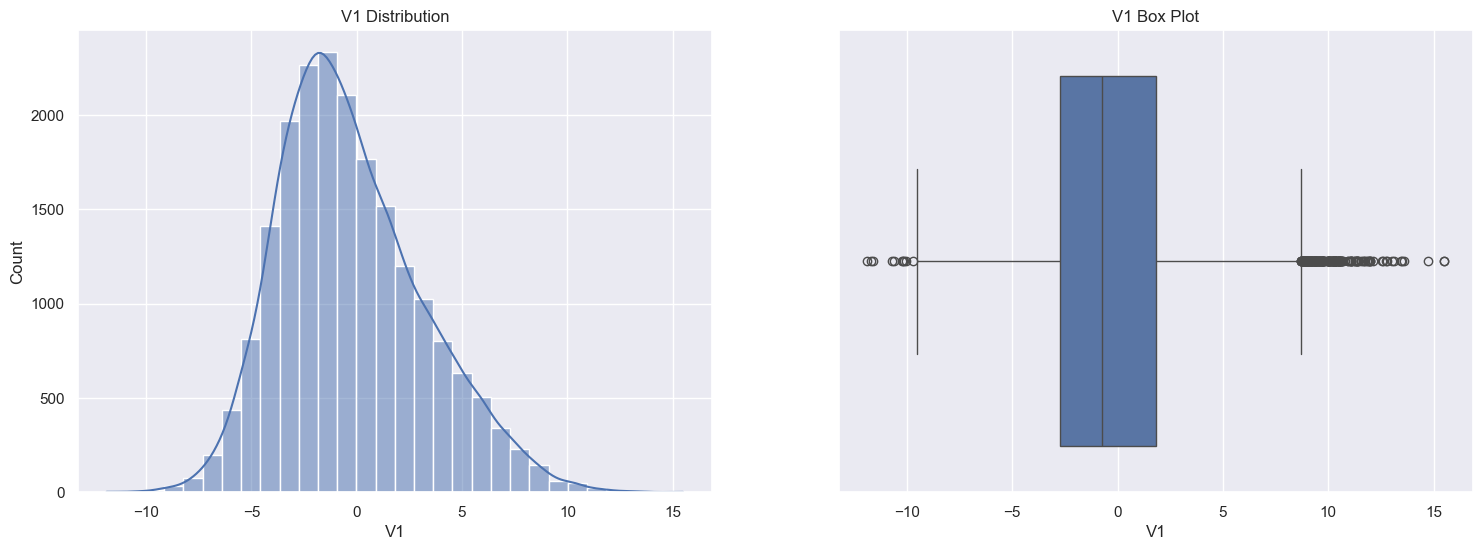

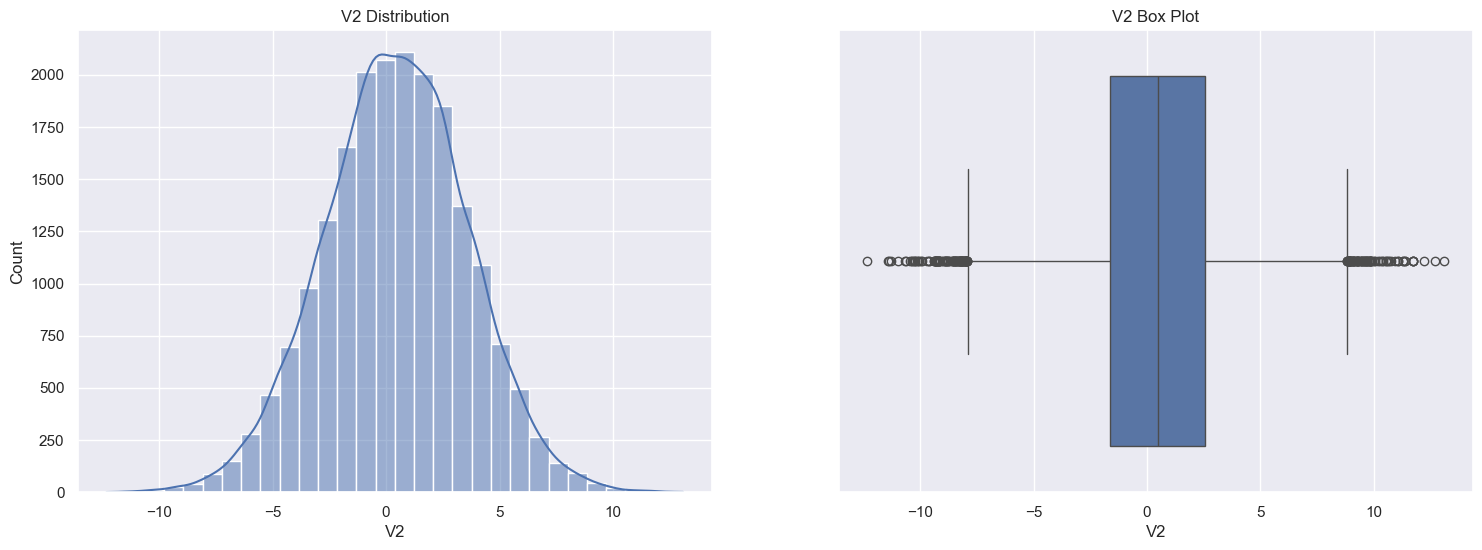

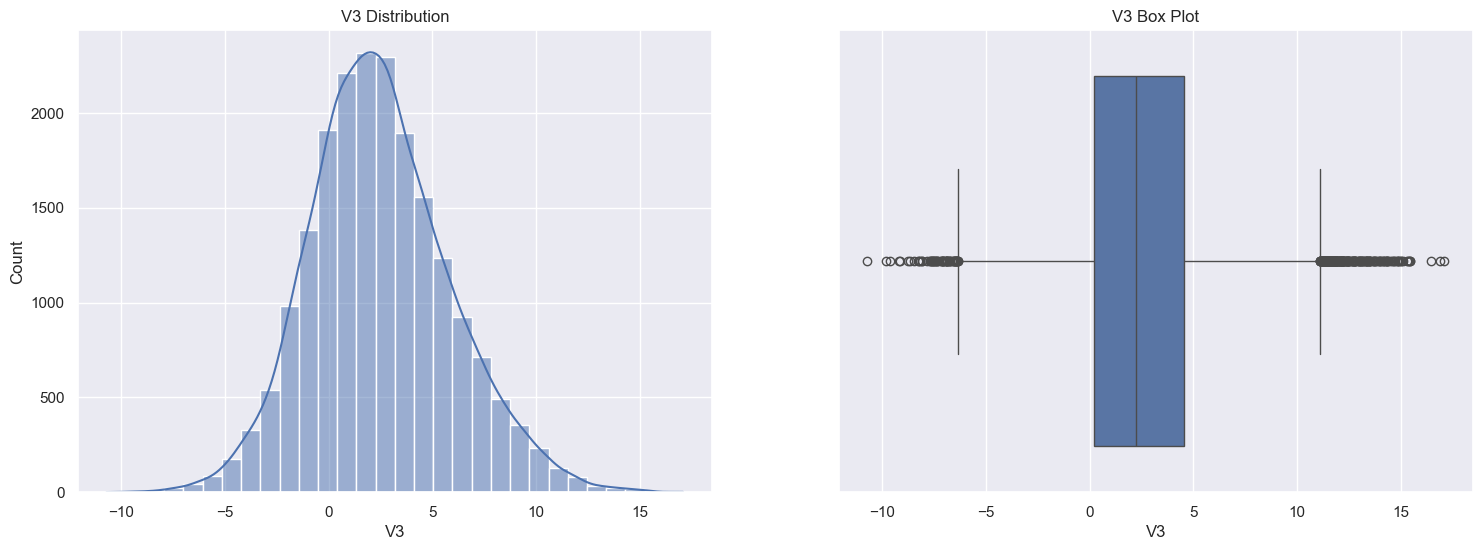

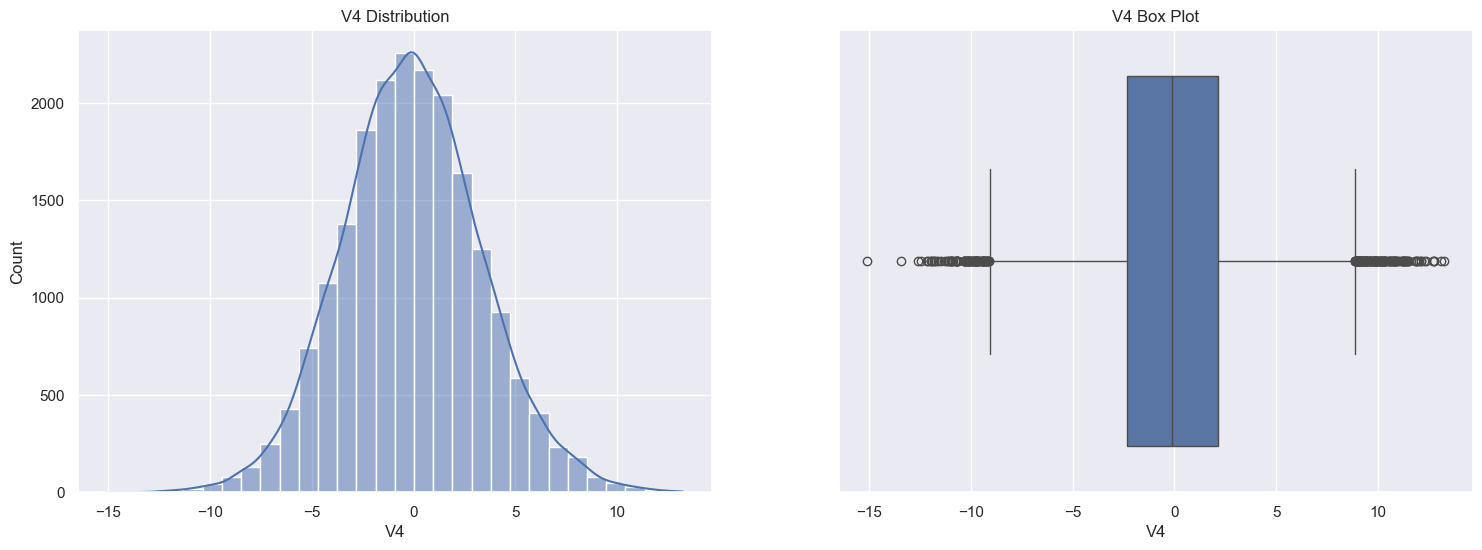

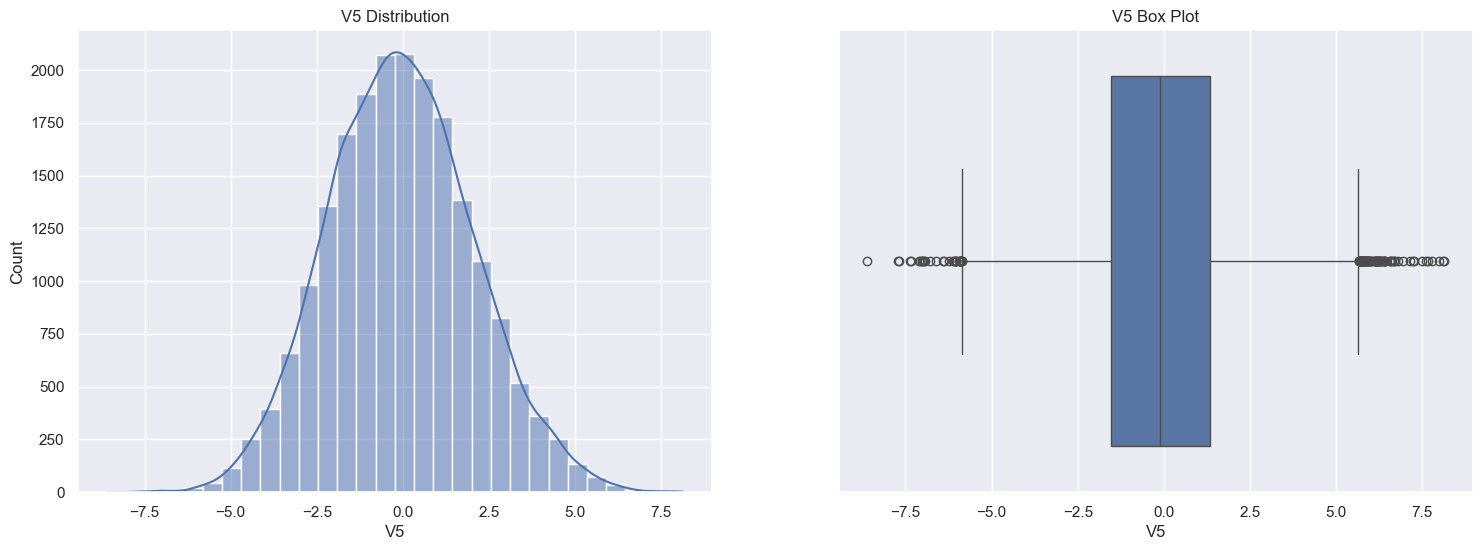

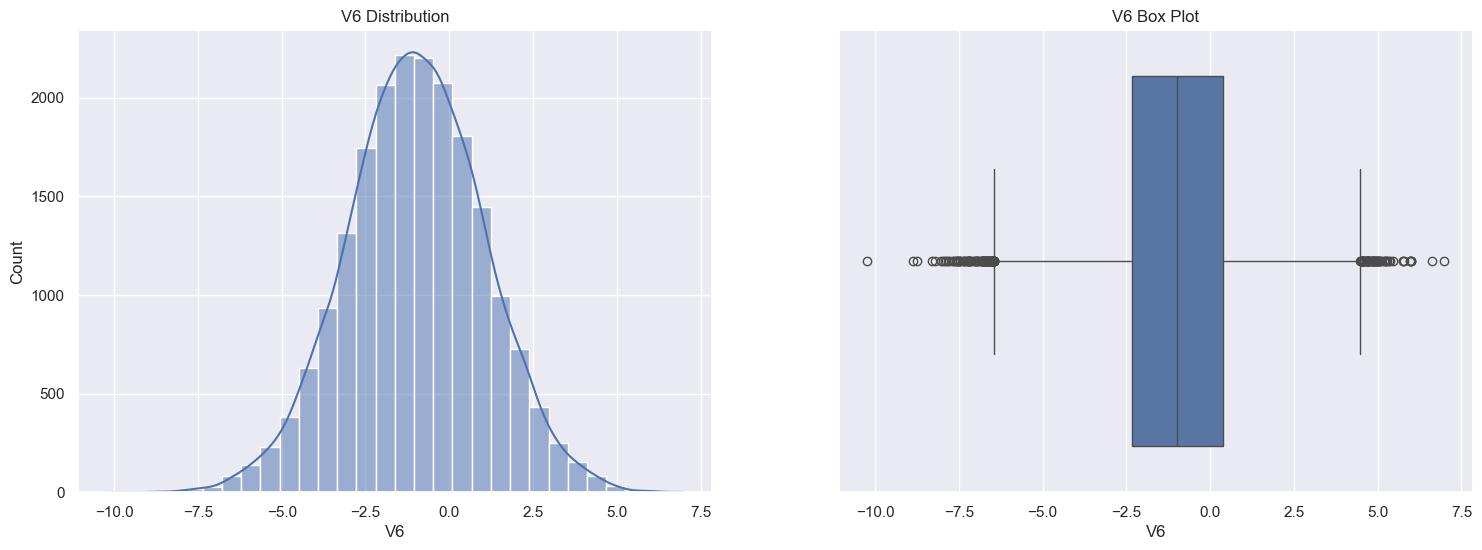

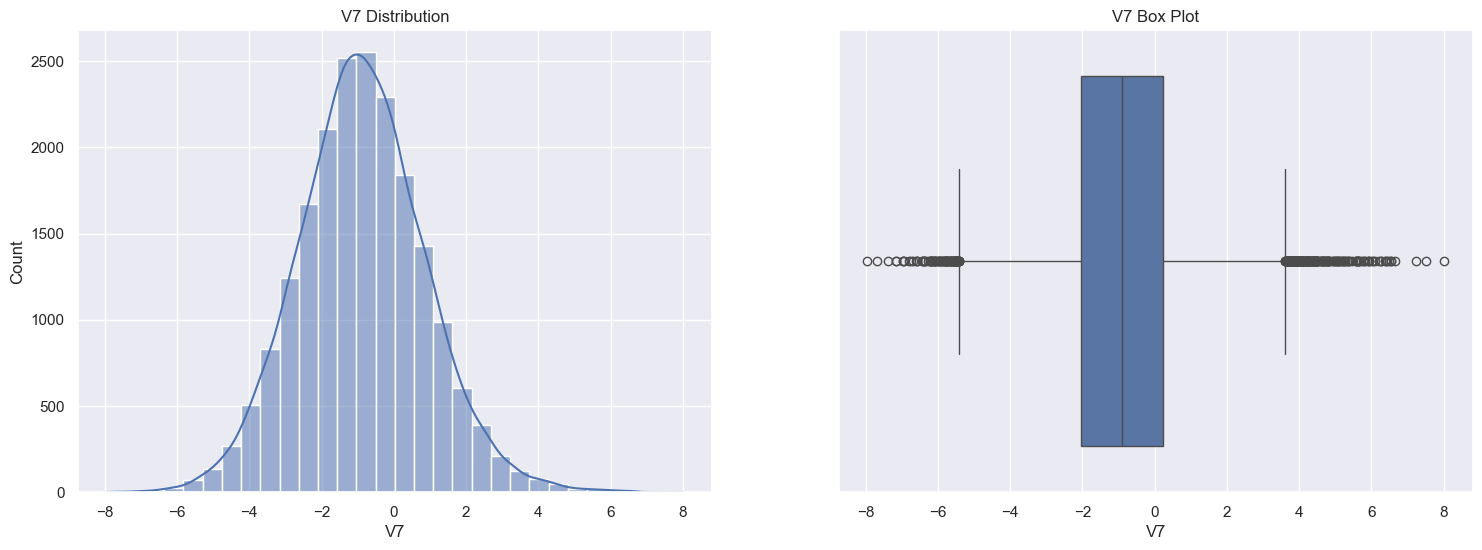

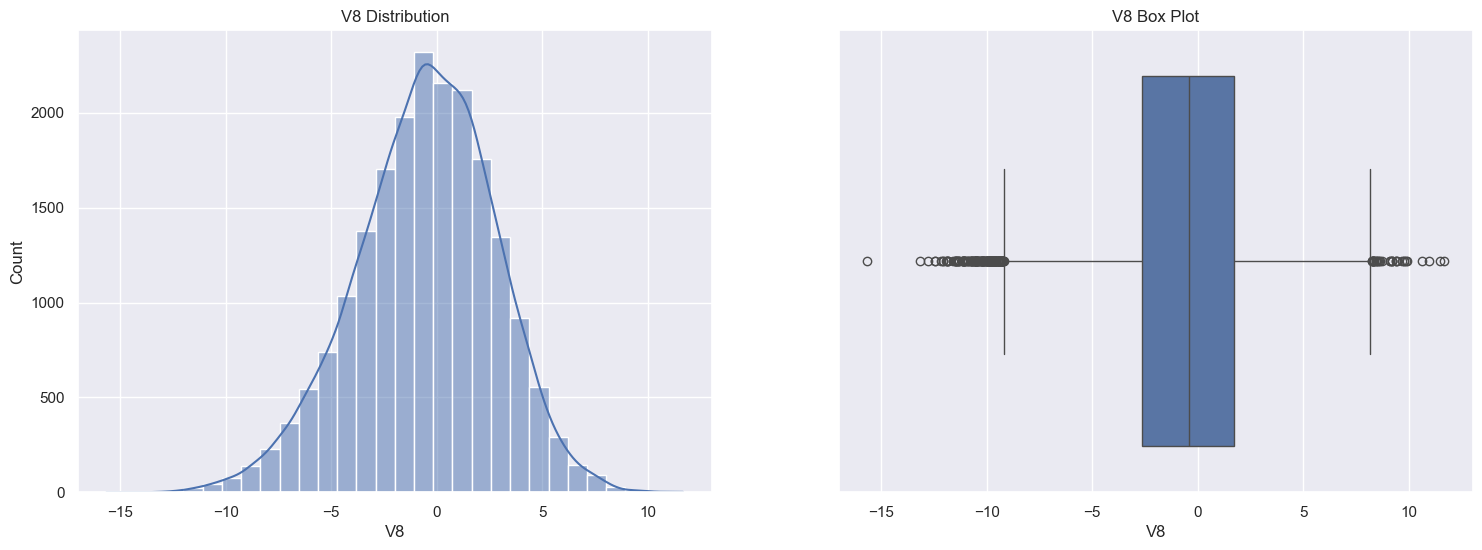

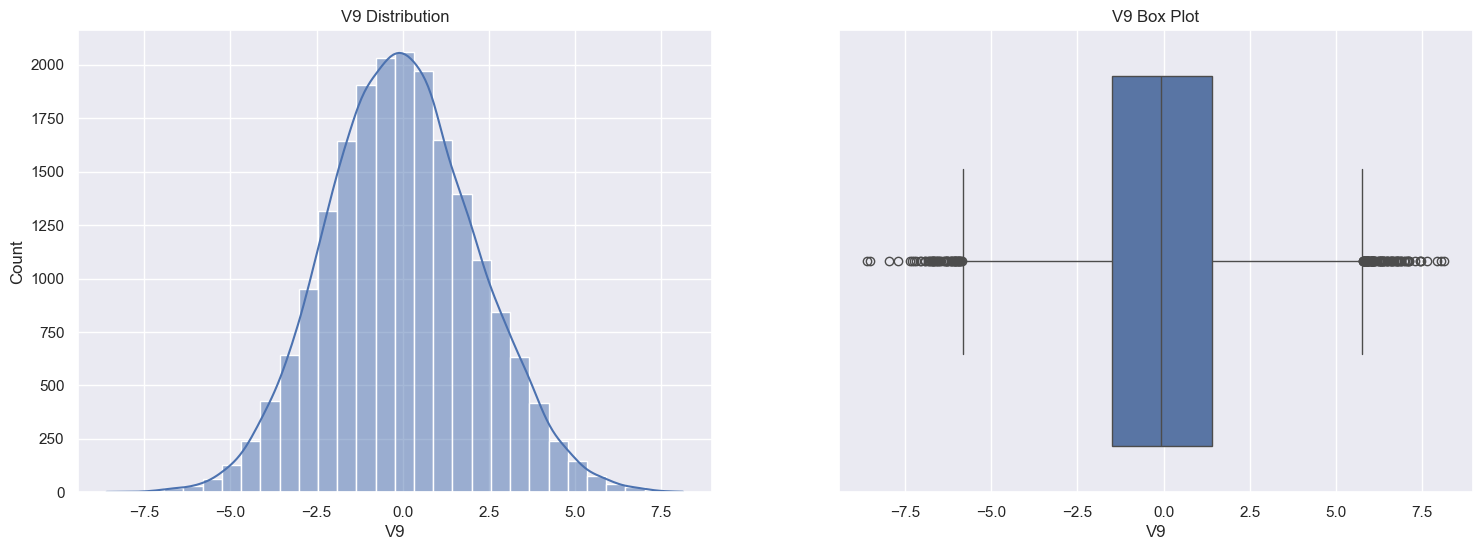

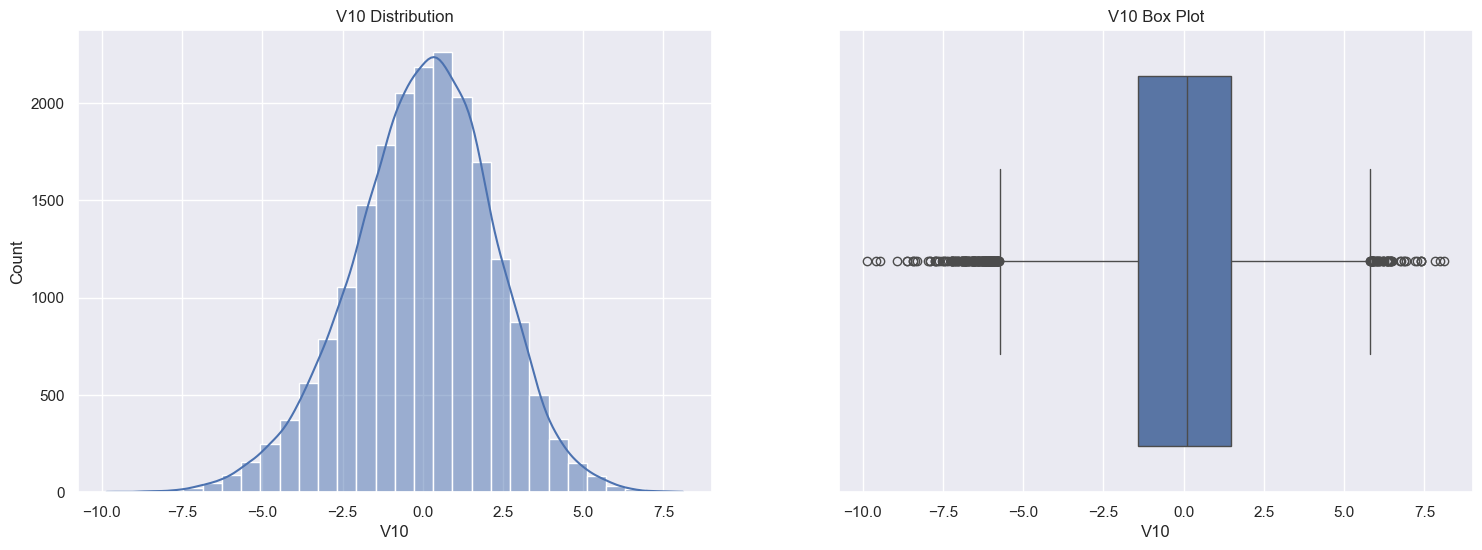

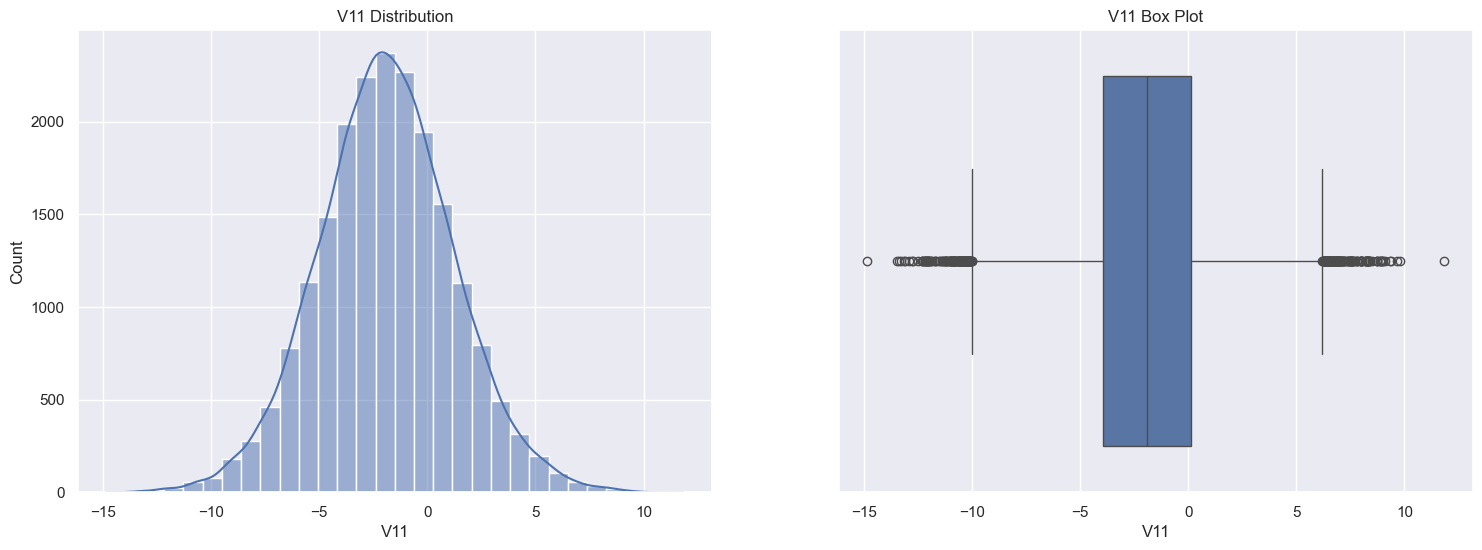

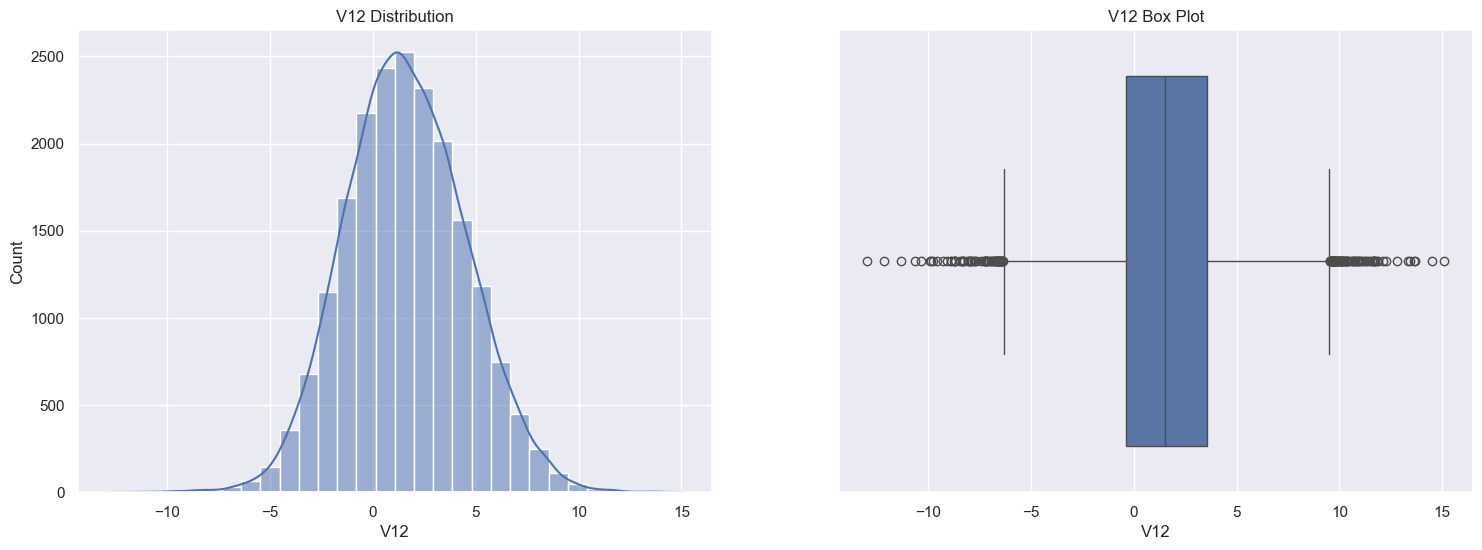

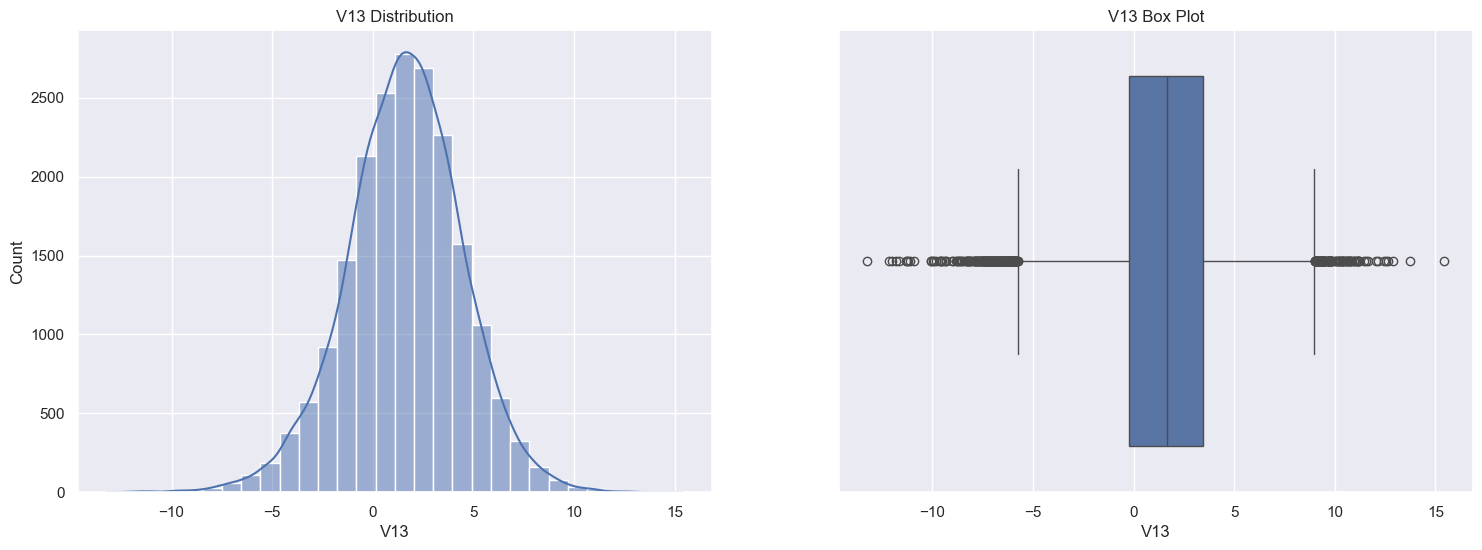

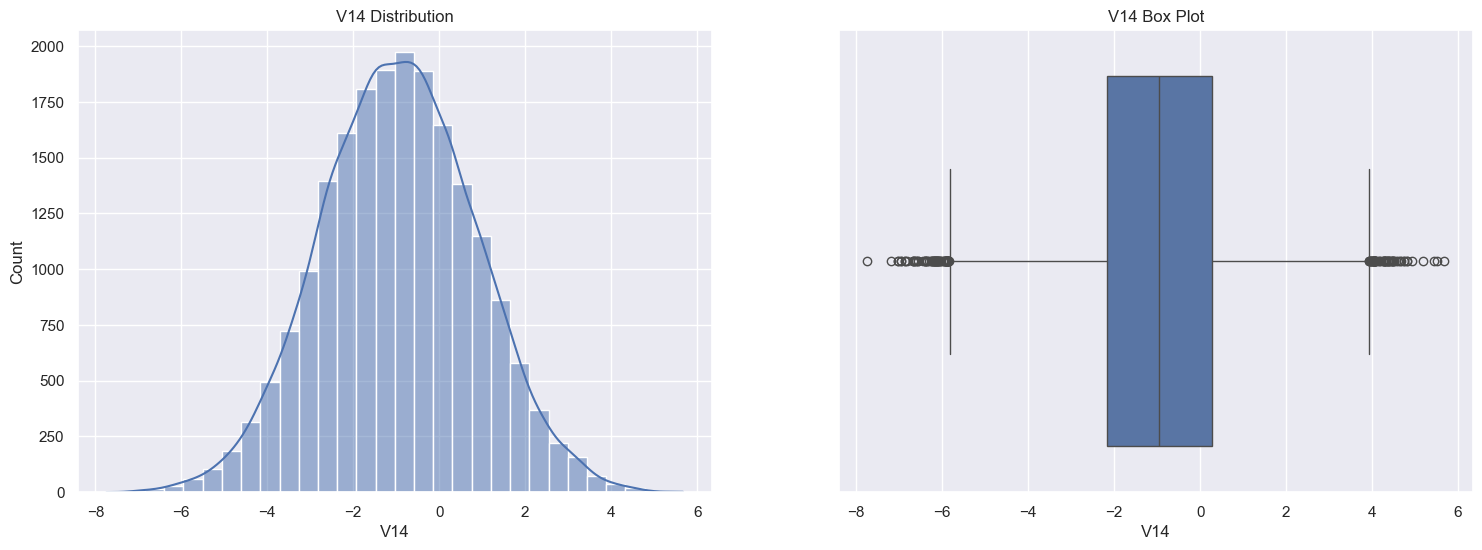

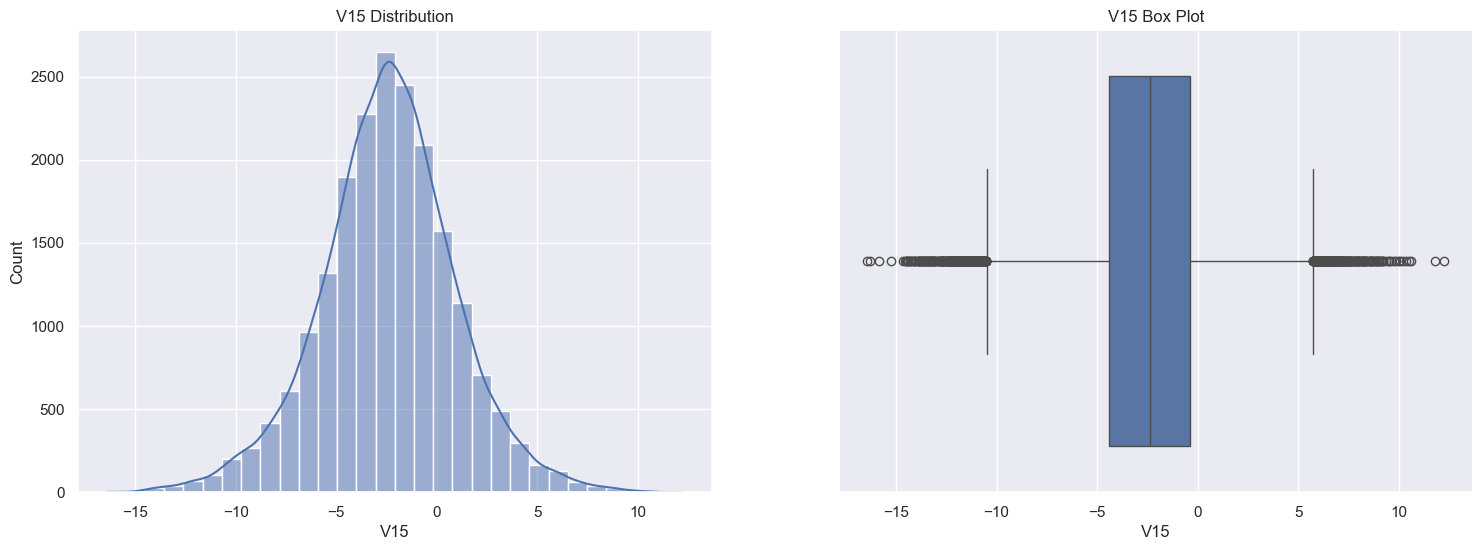

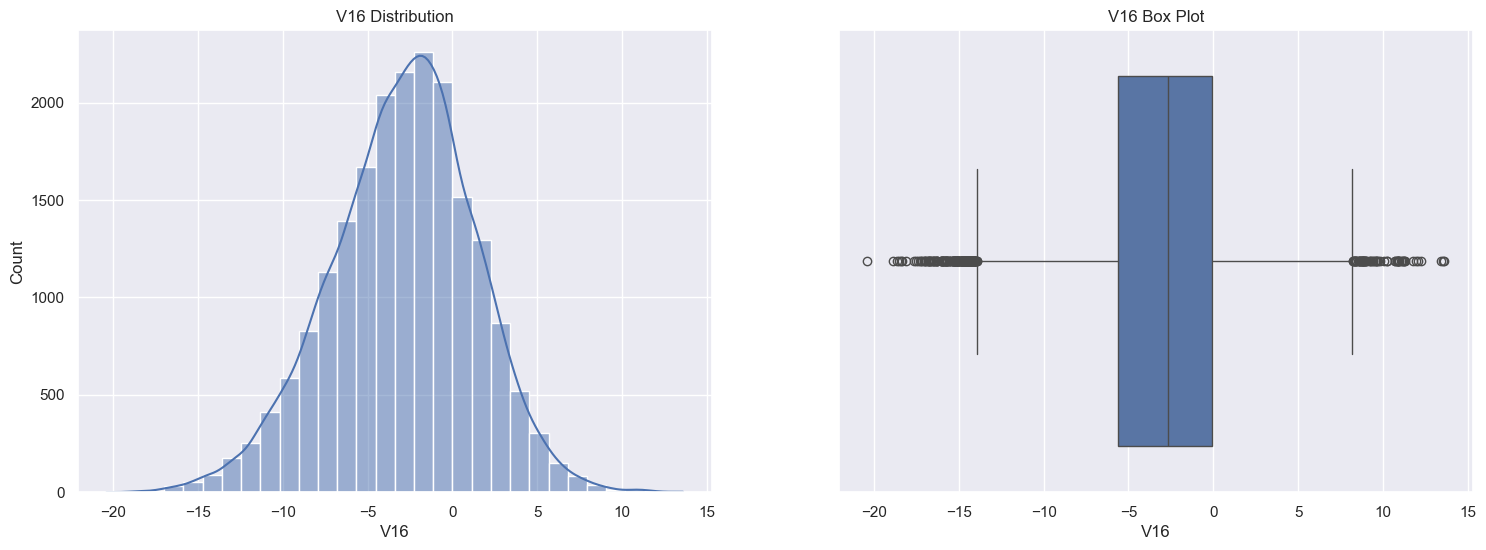

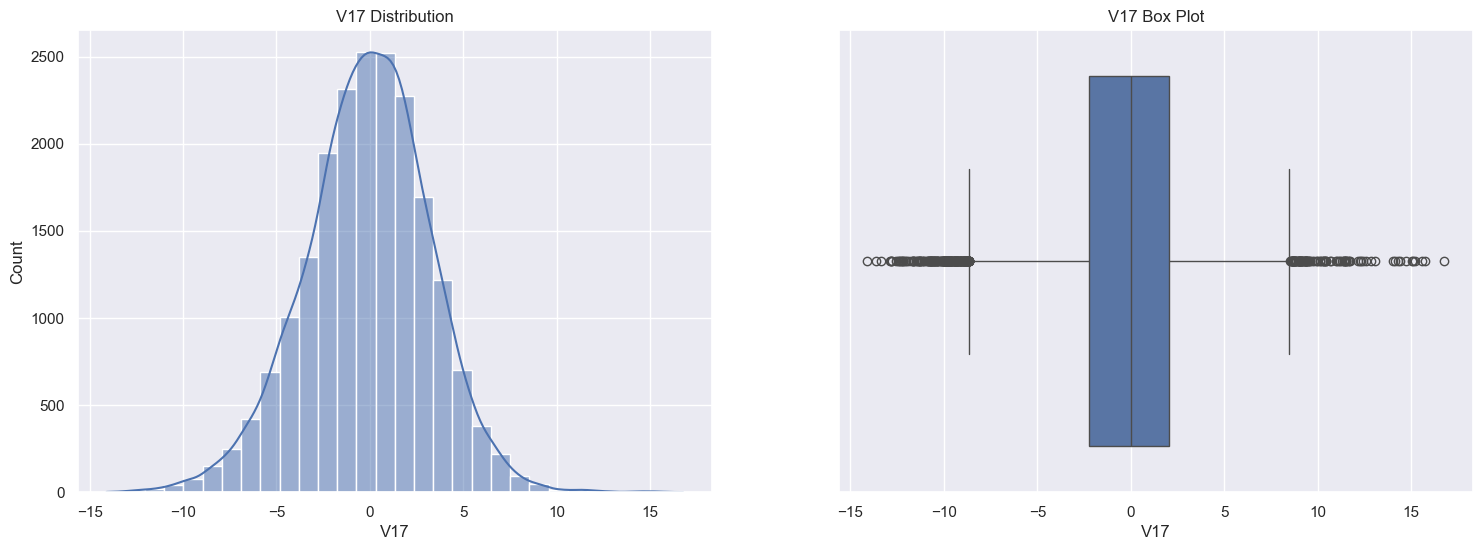

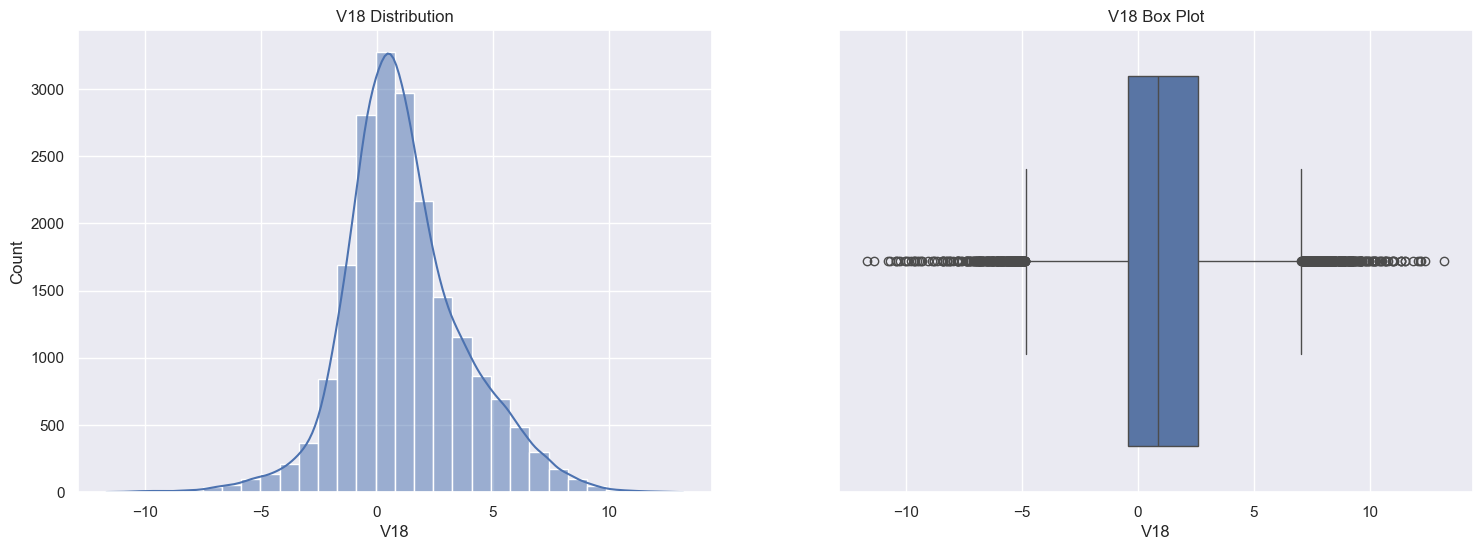

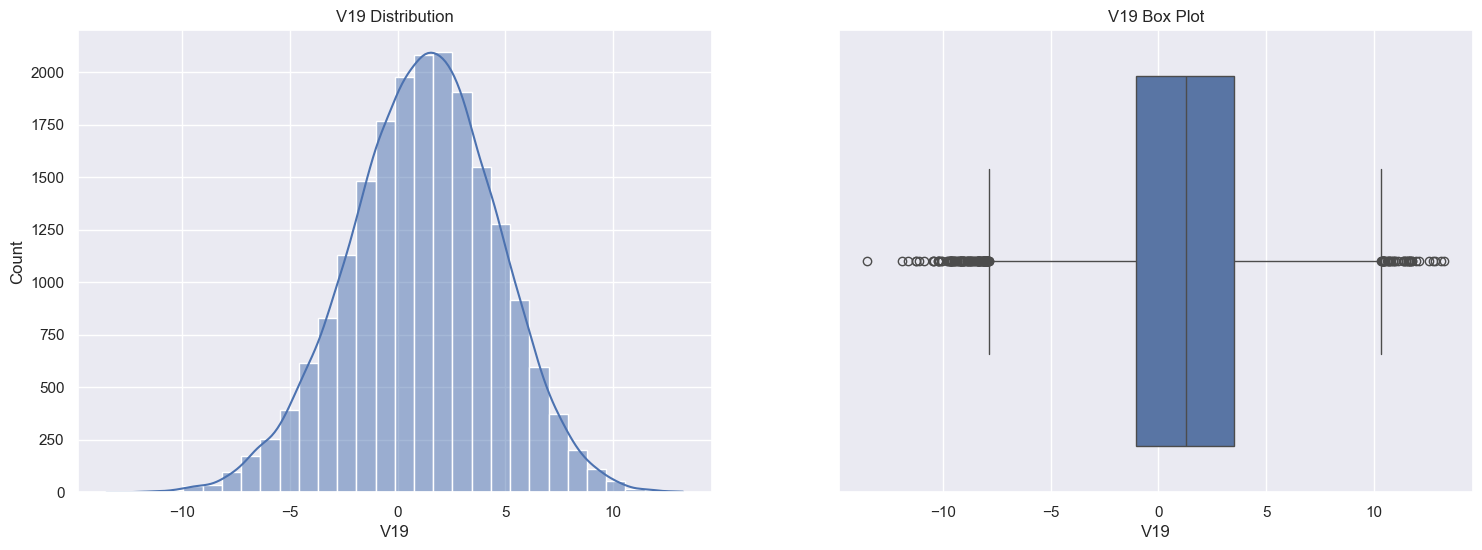

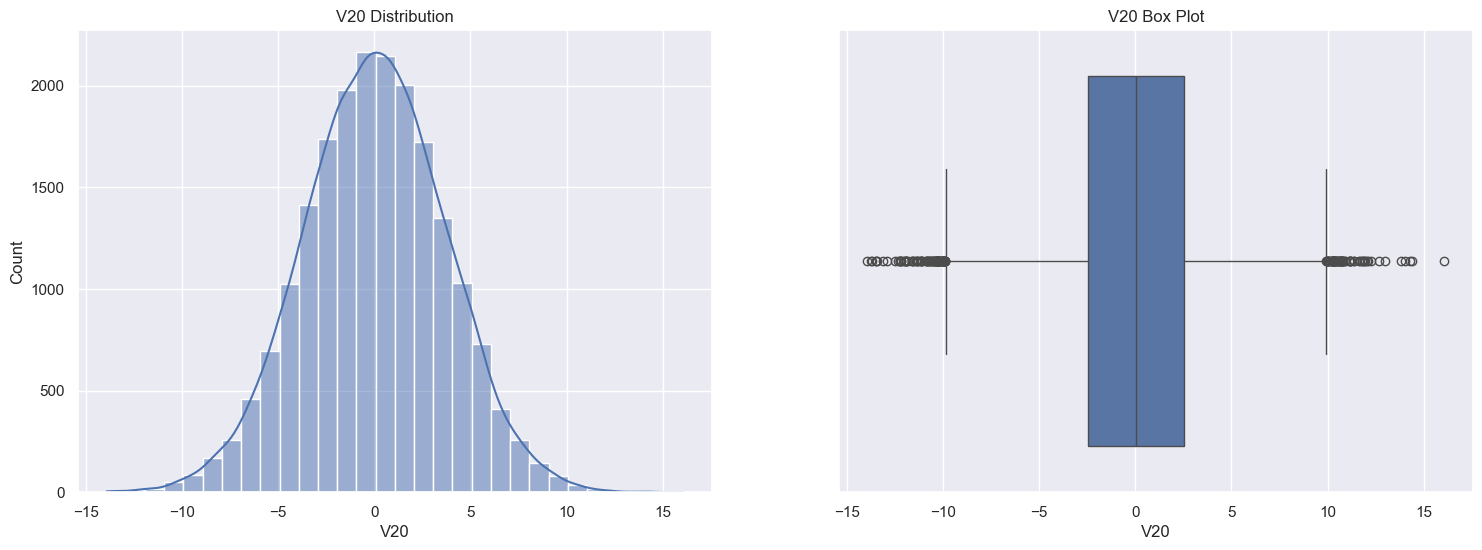

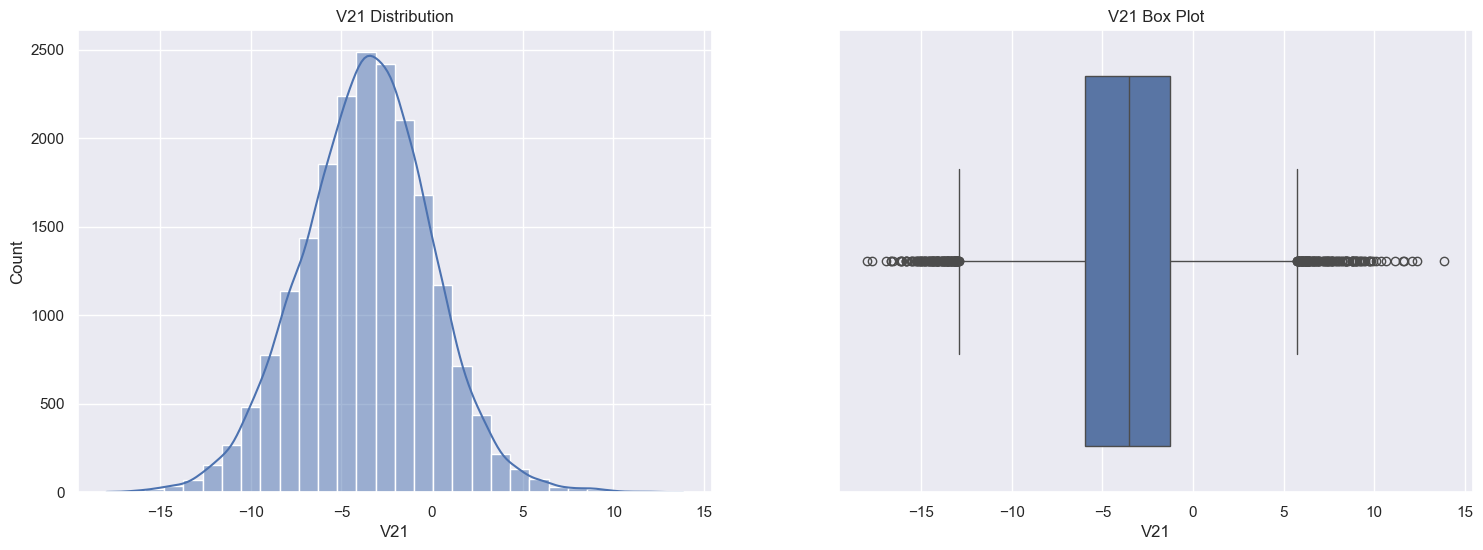

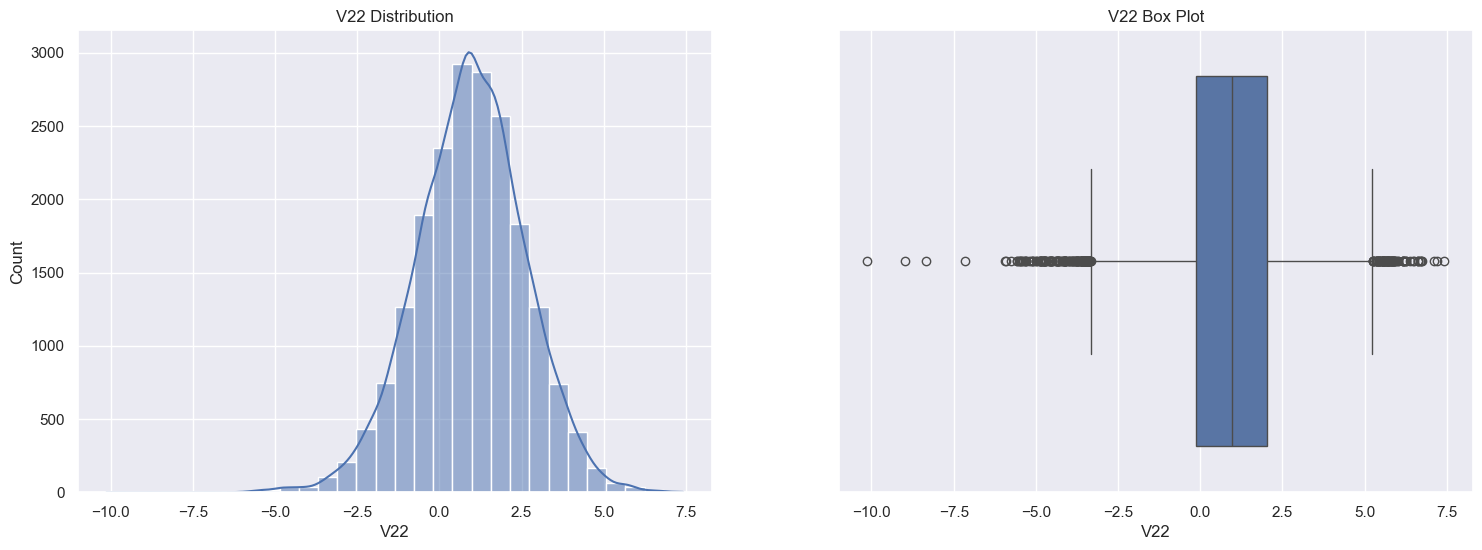

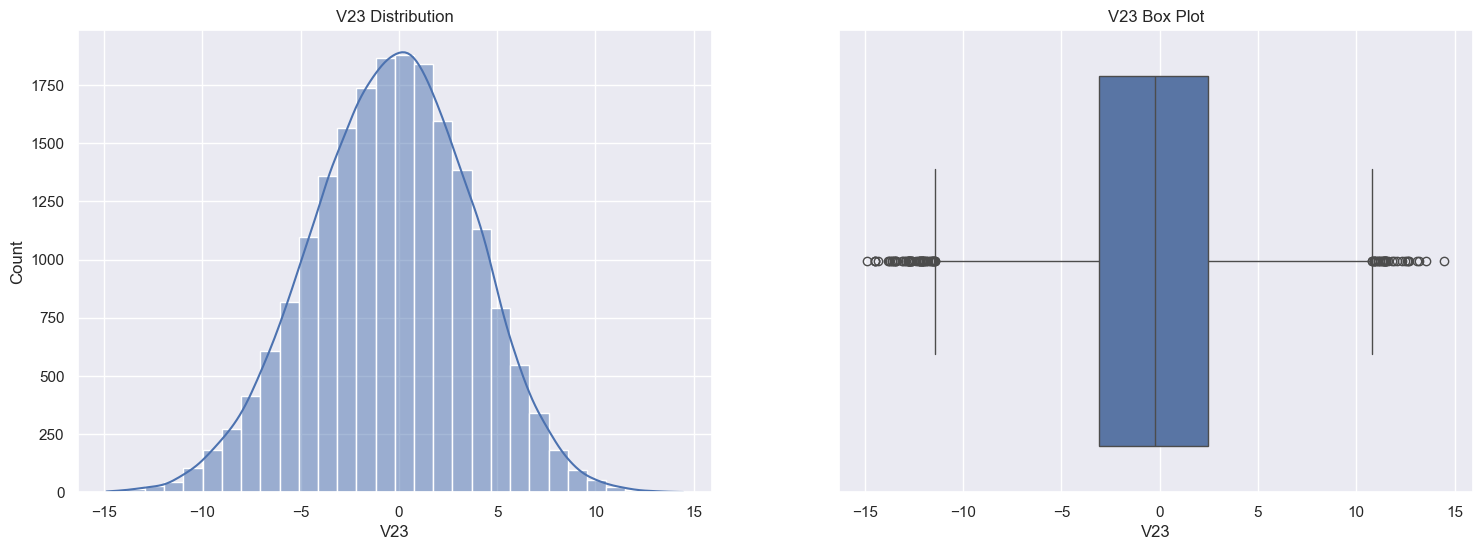

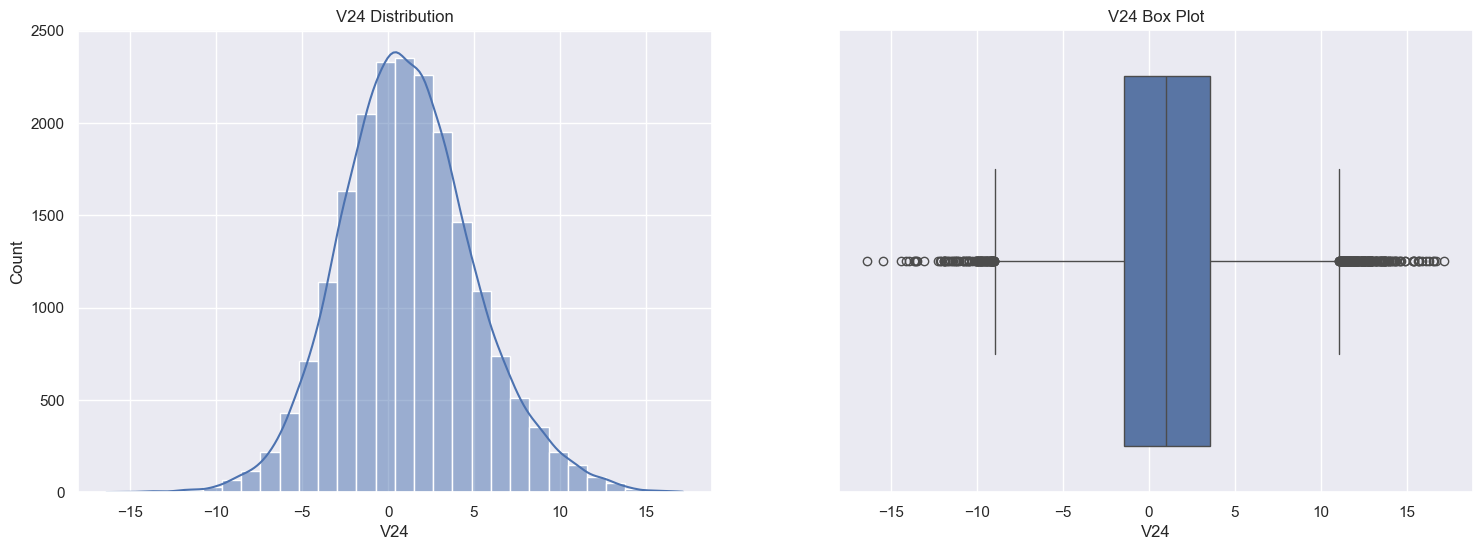

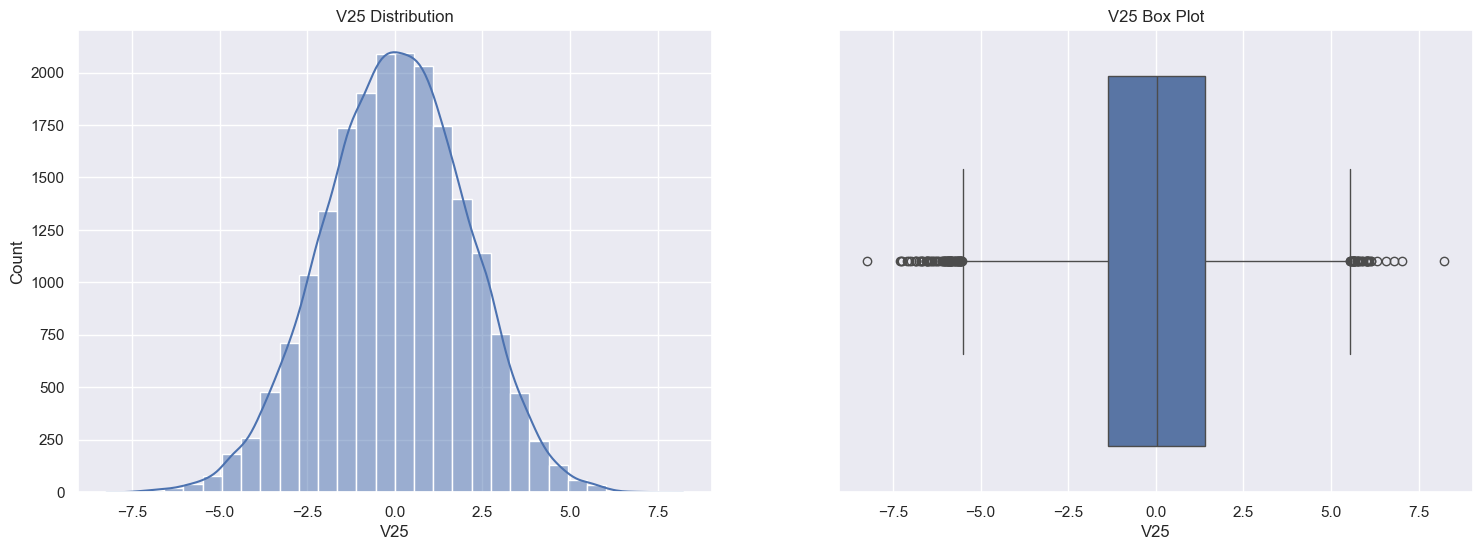

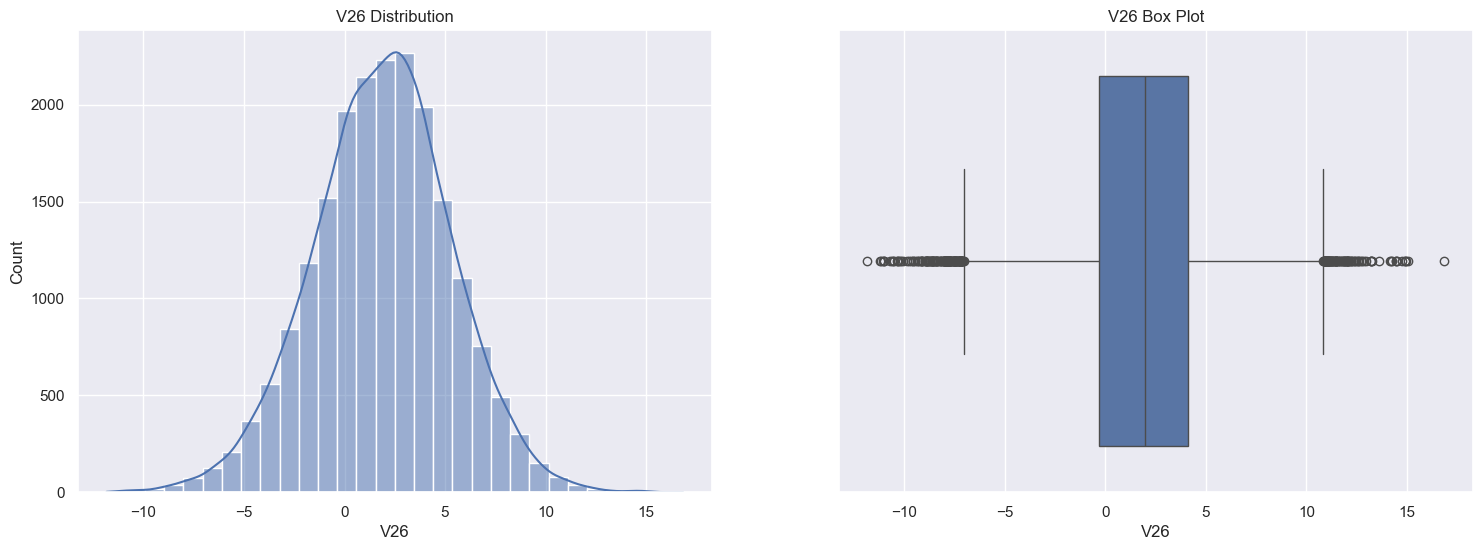

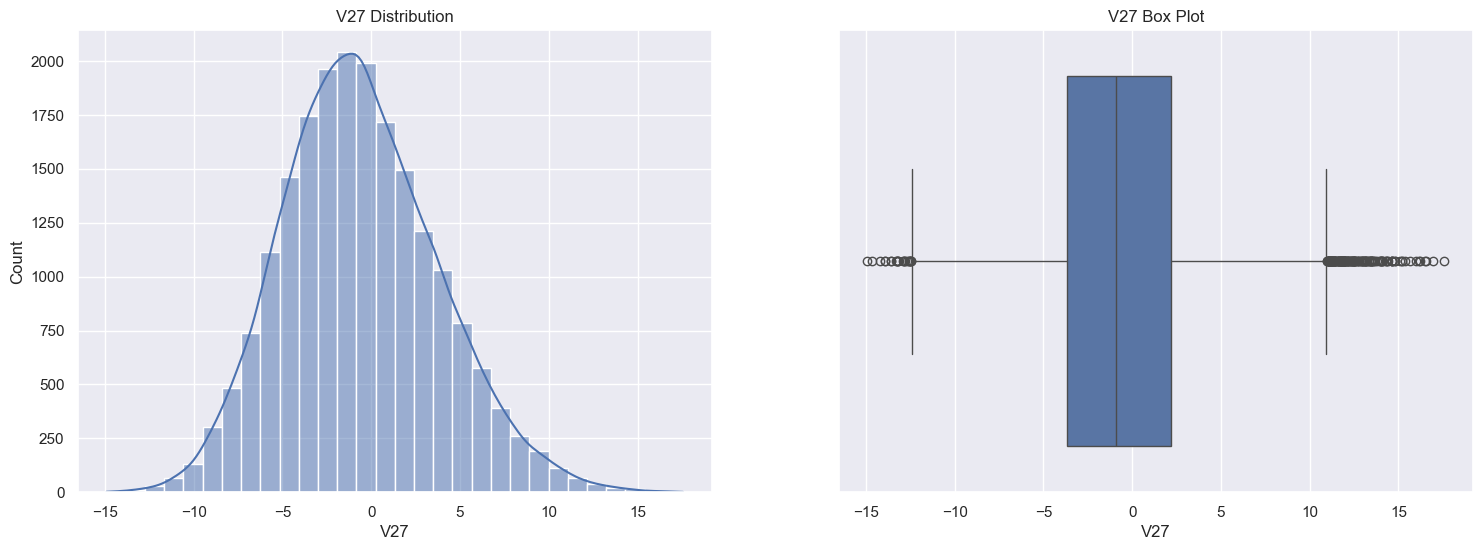

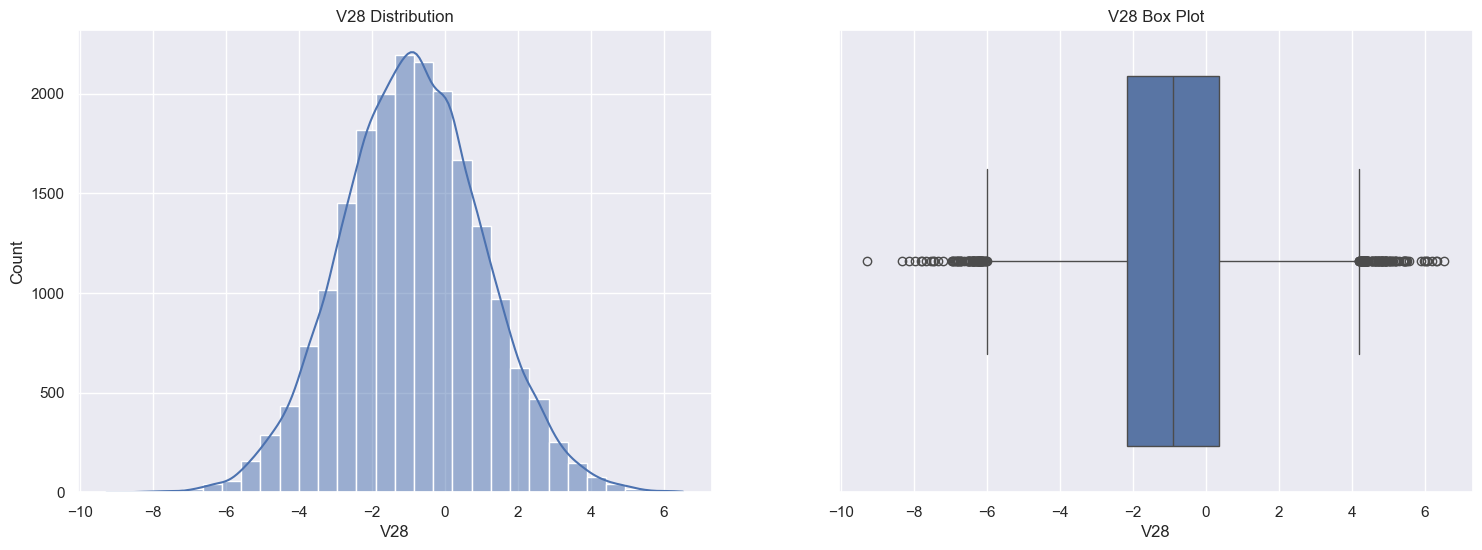

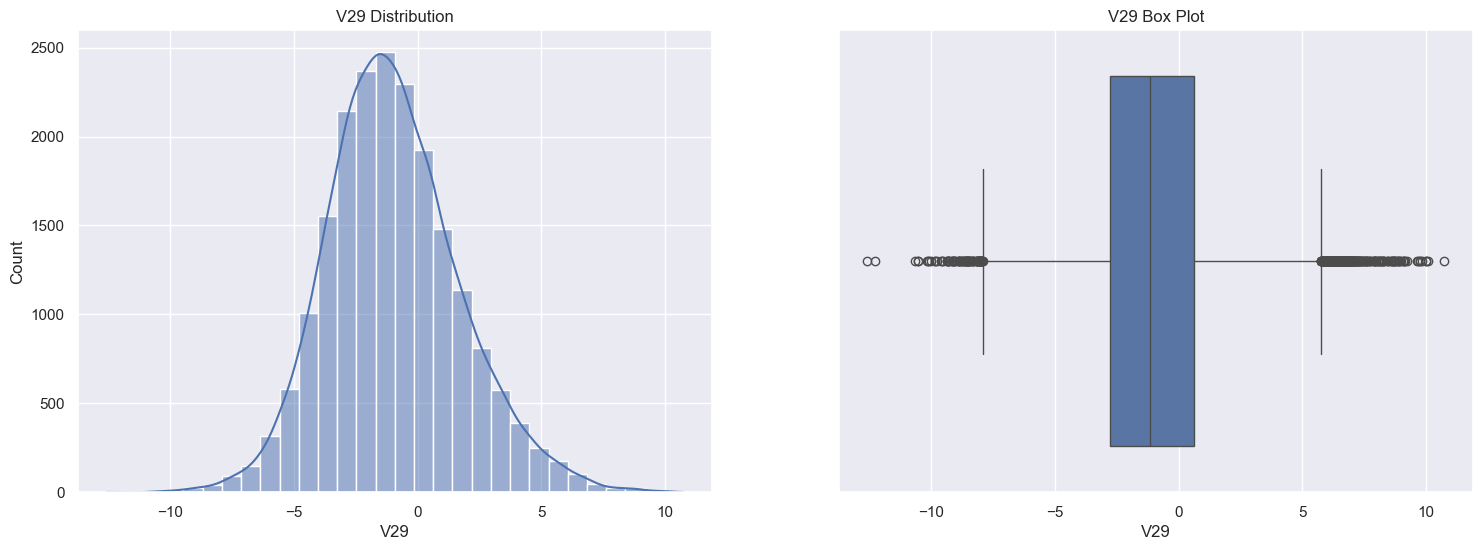

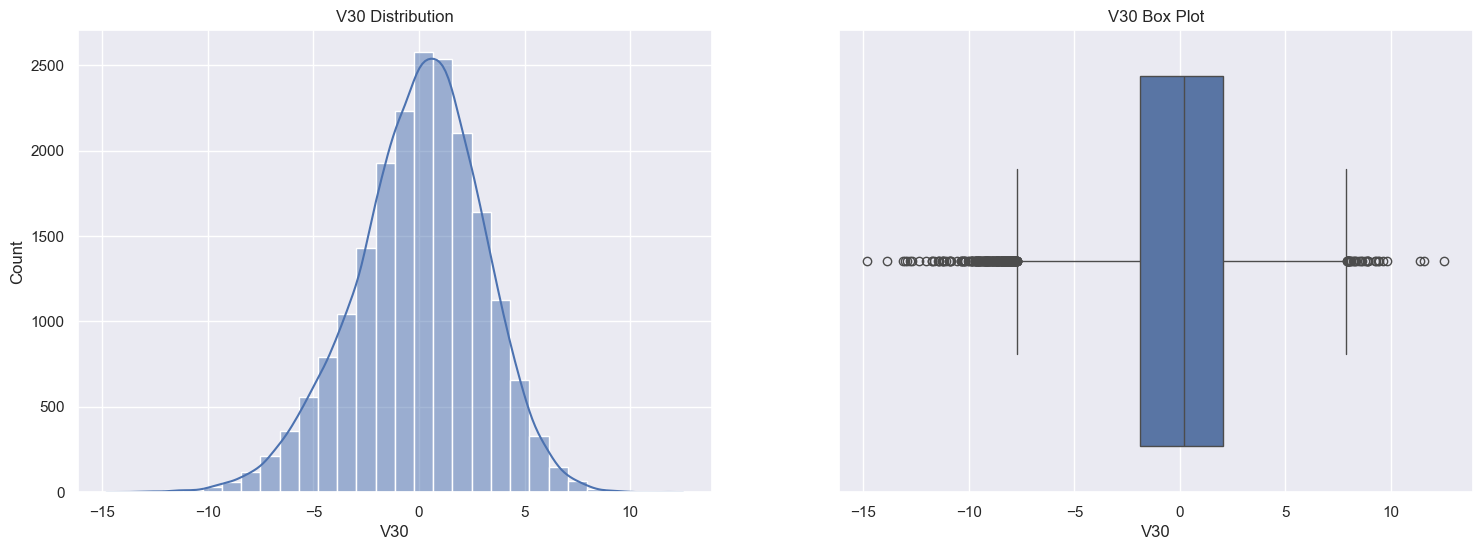

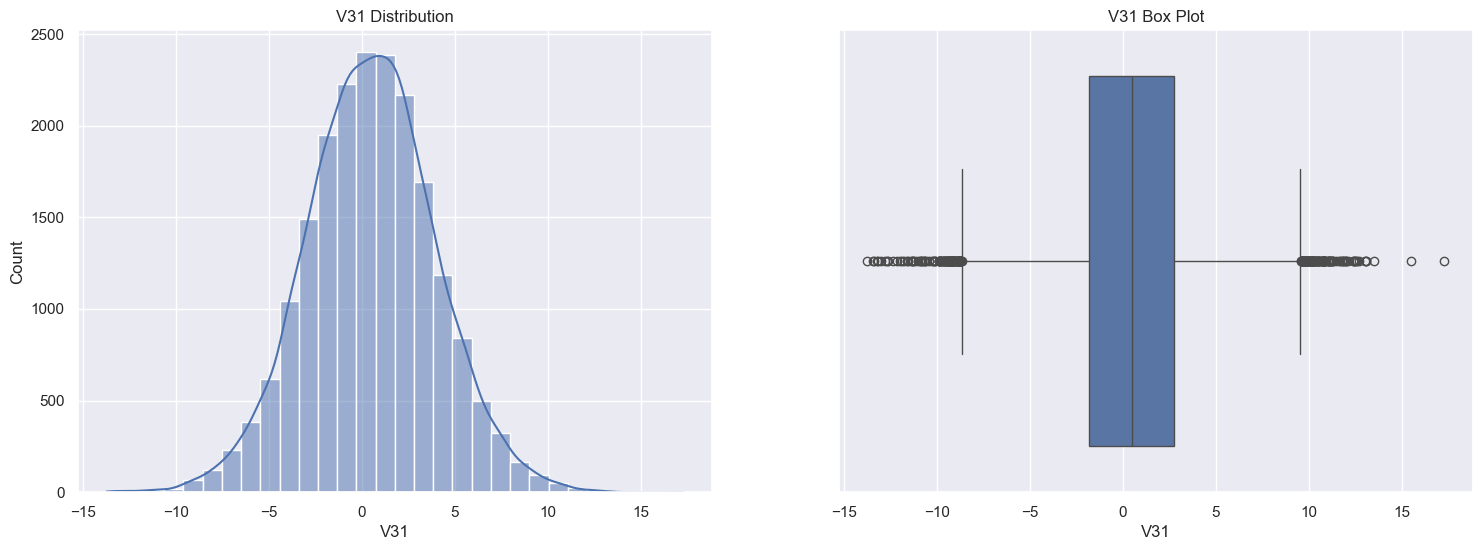

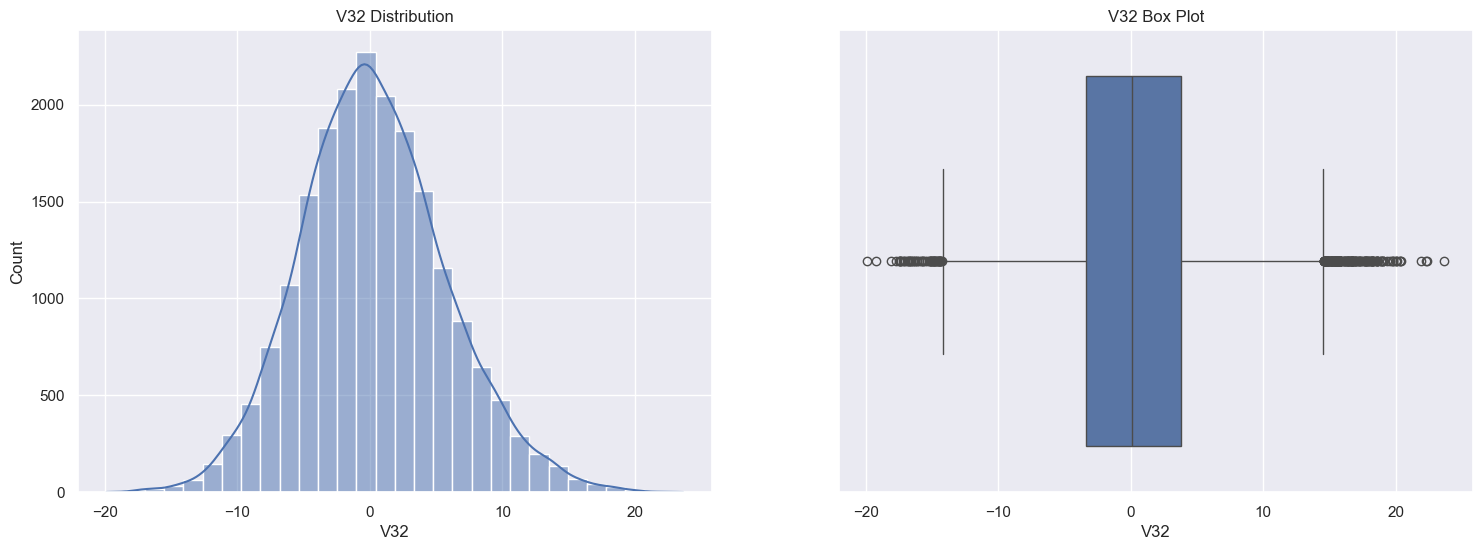

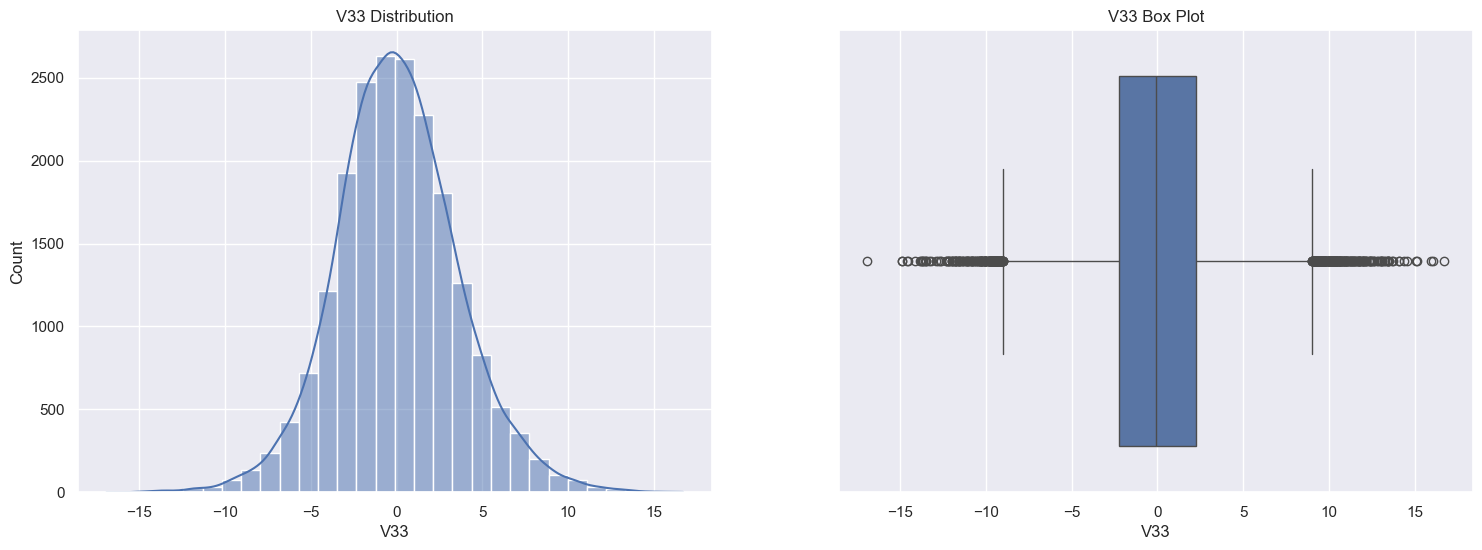

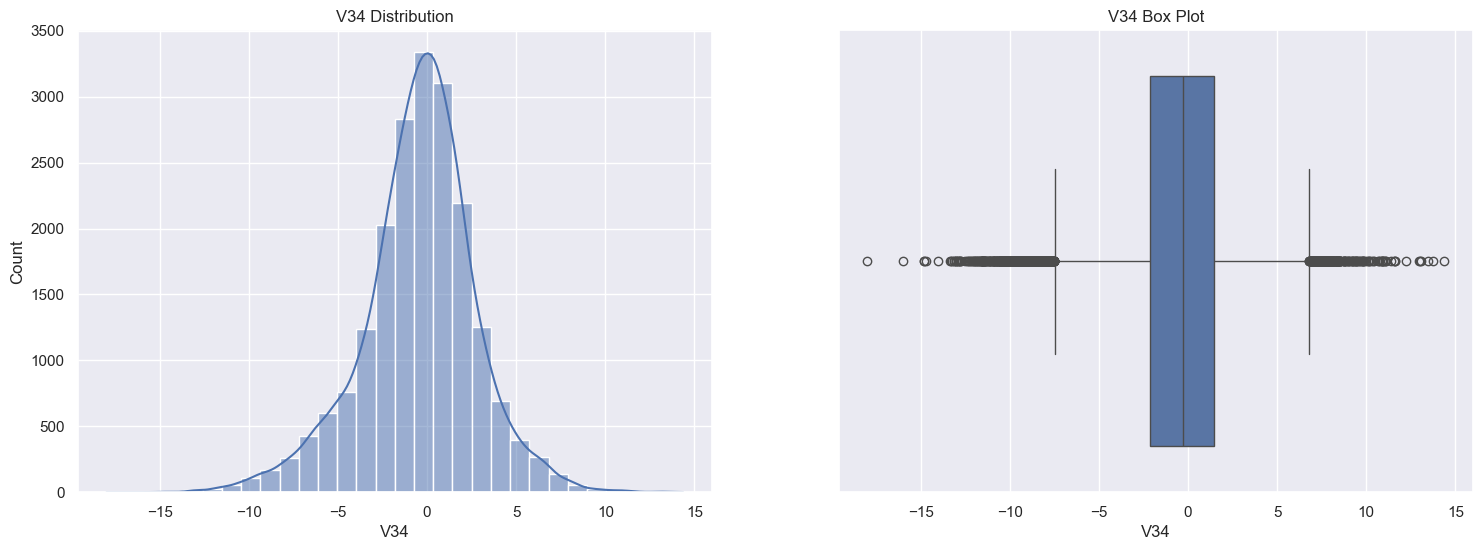

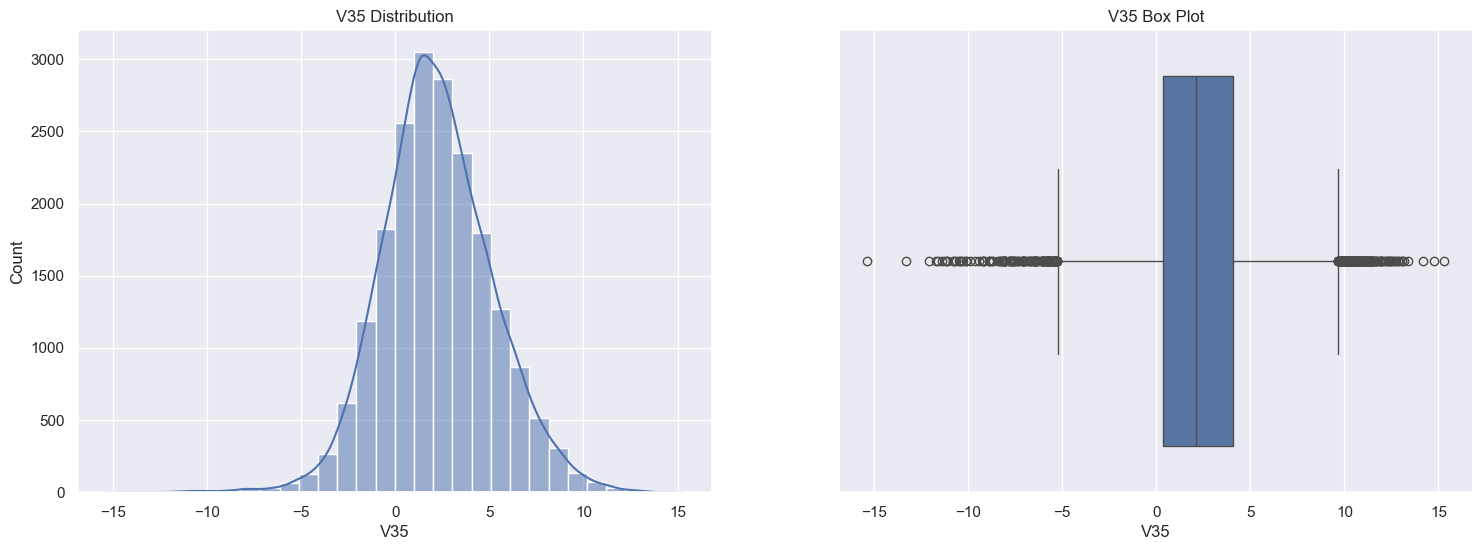

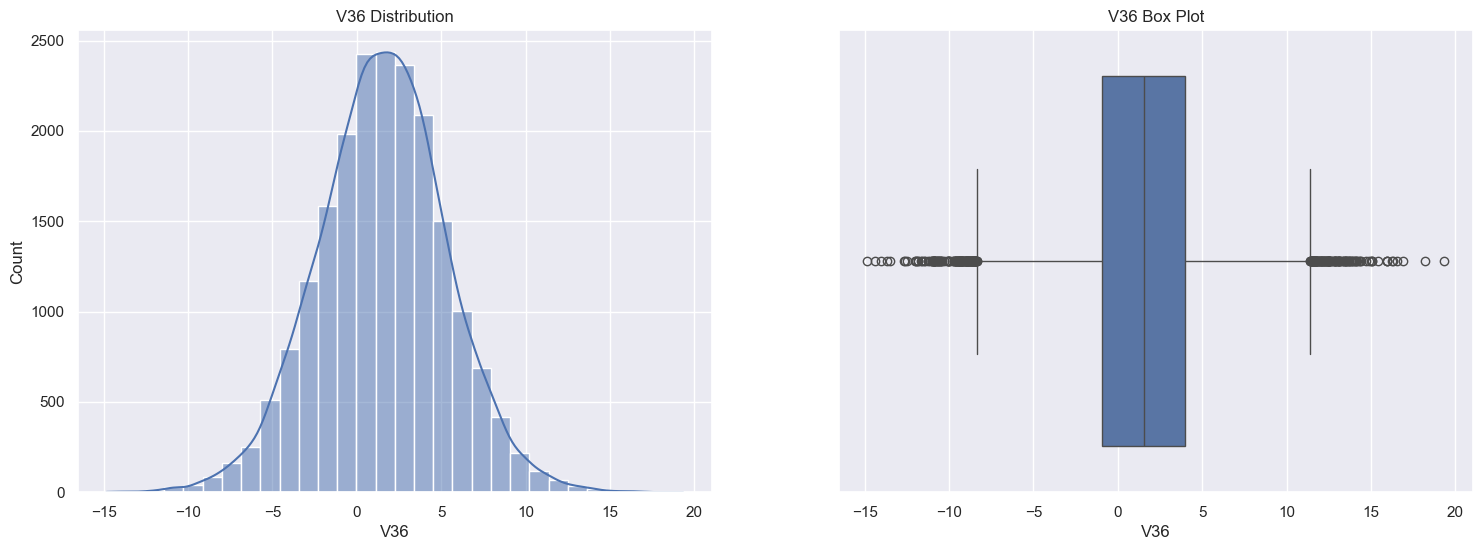

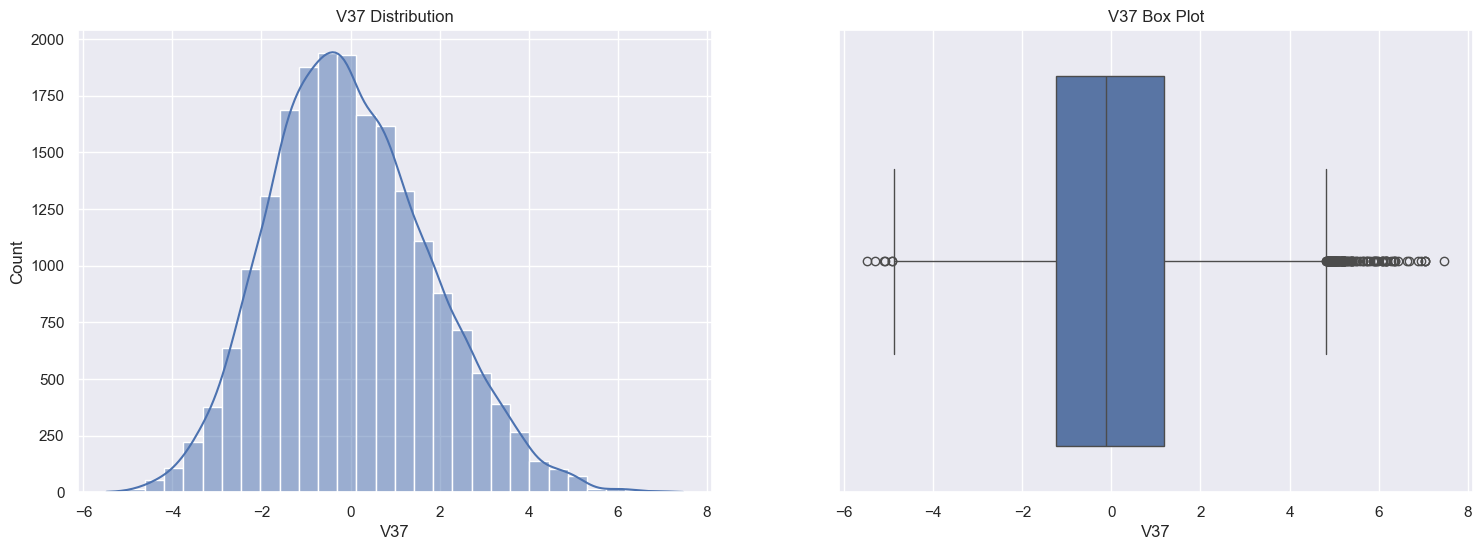

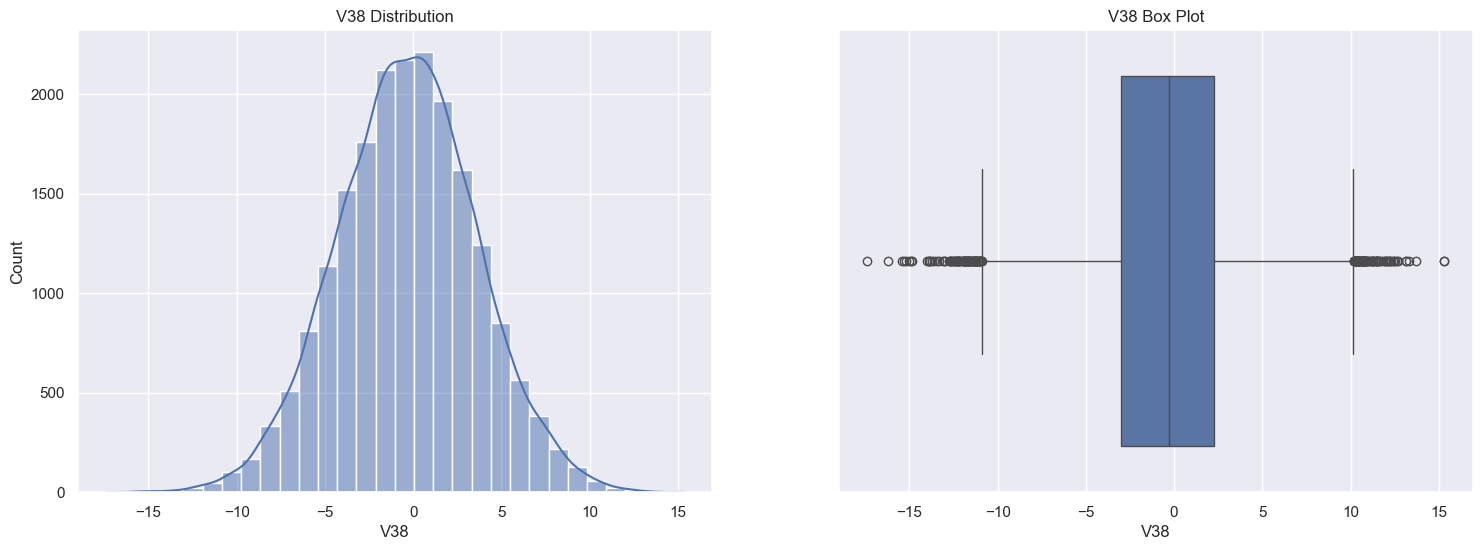

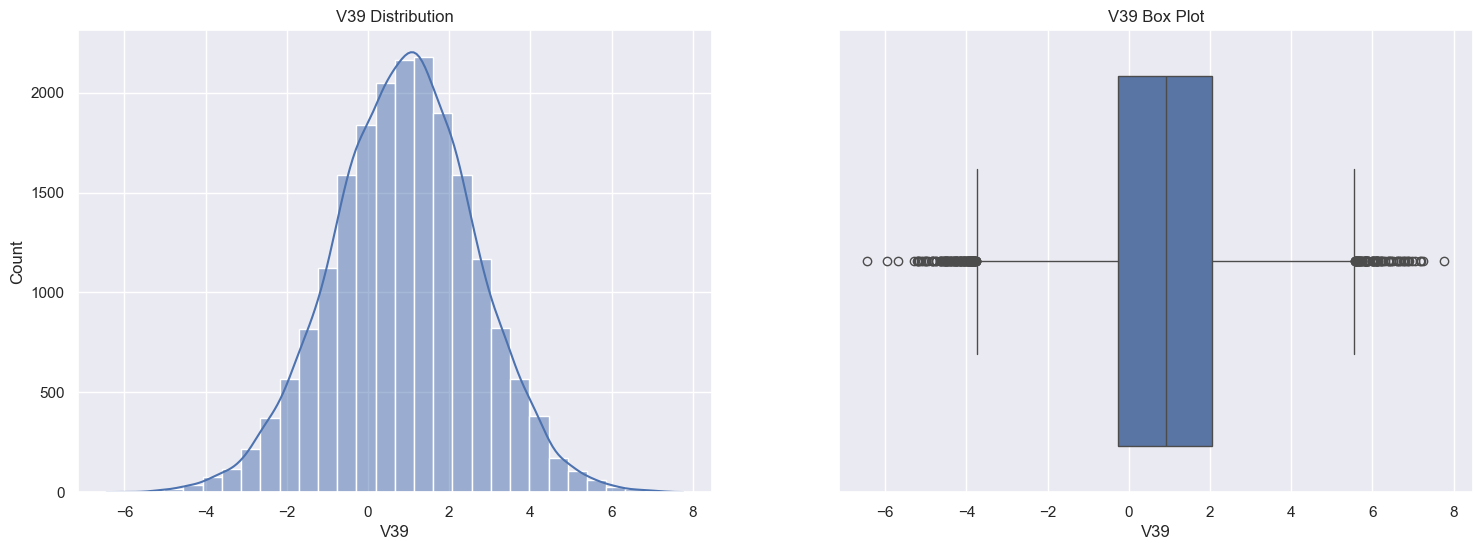

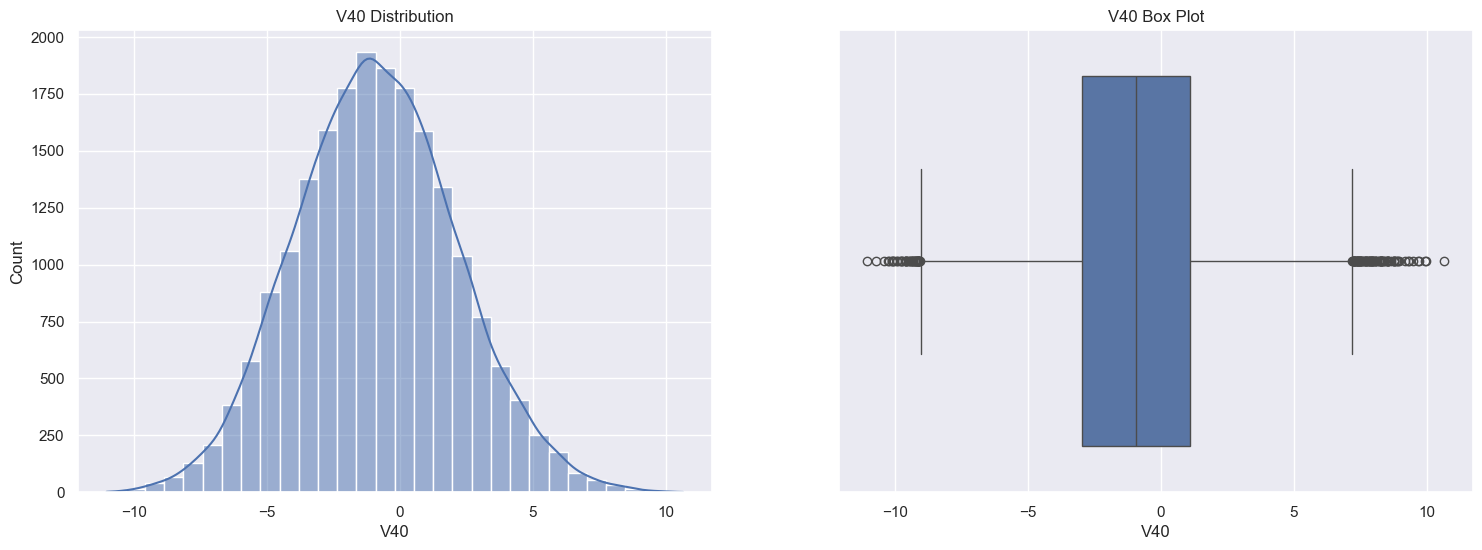

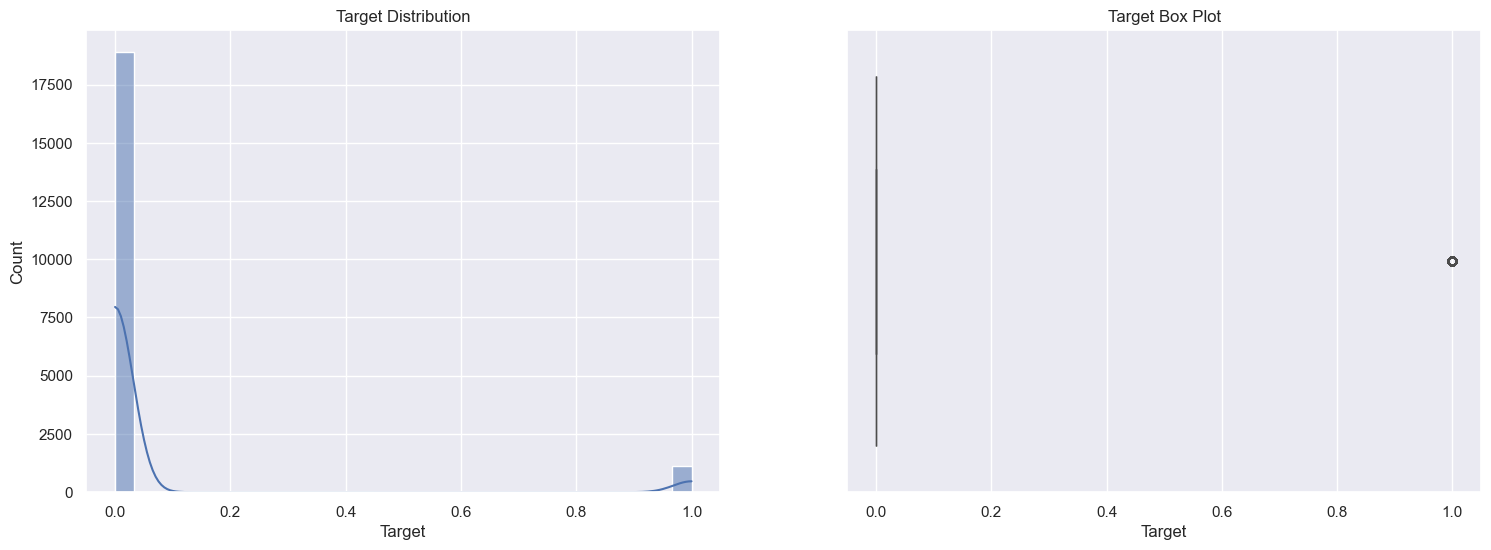

In [13]:
#Get the list of all columns in train_data_copy
all_columns = train_data_copy.columns.tolist()

#Since there are a total of 40 input variables, and 1 output variable we will perform a loop of the histogram plot and box plot for each of the input variables
for column in all_columns:
    draw_boxplot_and_histogram(train_data_copy, column)
    plt.show()

* The input variables V1-V40 are all more or less normally distributed.
* The input variables V1-V40 all have outliers based on the box plot diagram.
* The Target variable does not exhibit any sort of normal distribution at all

## Bivariate Analysis

### Histogram ###

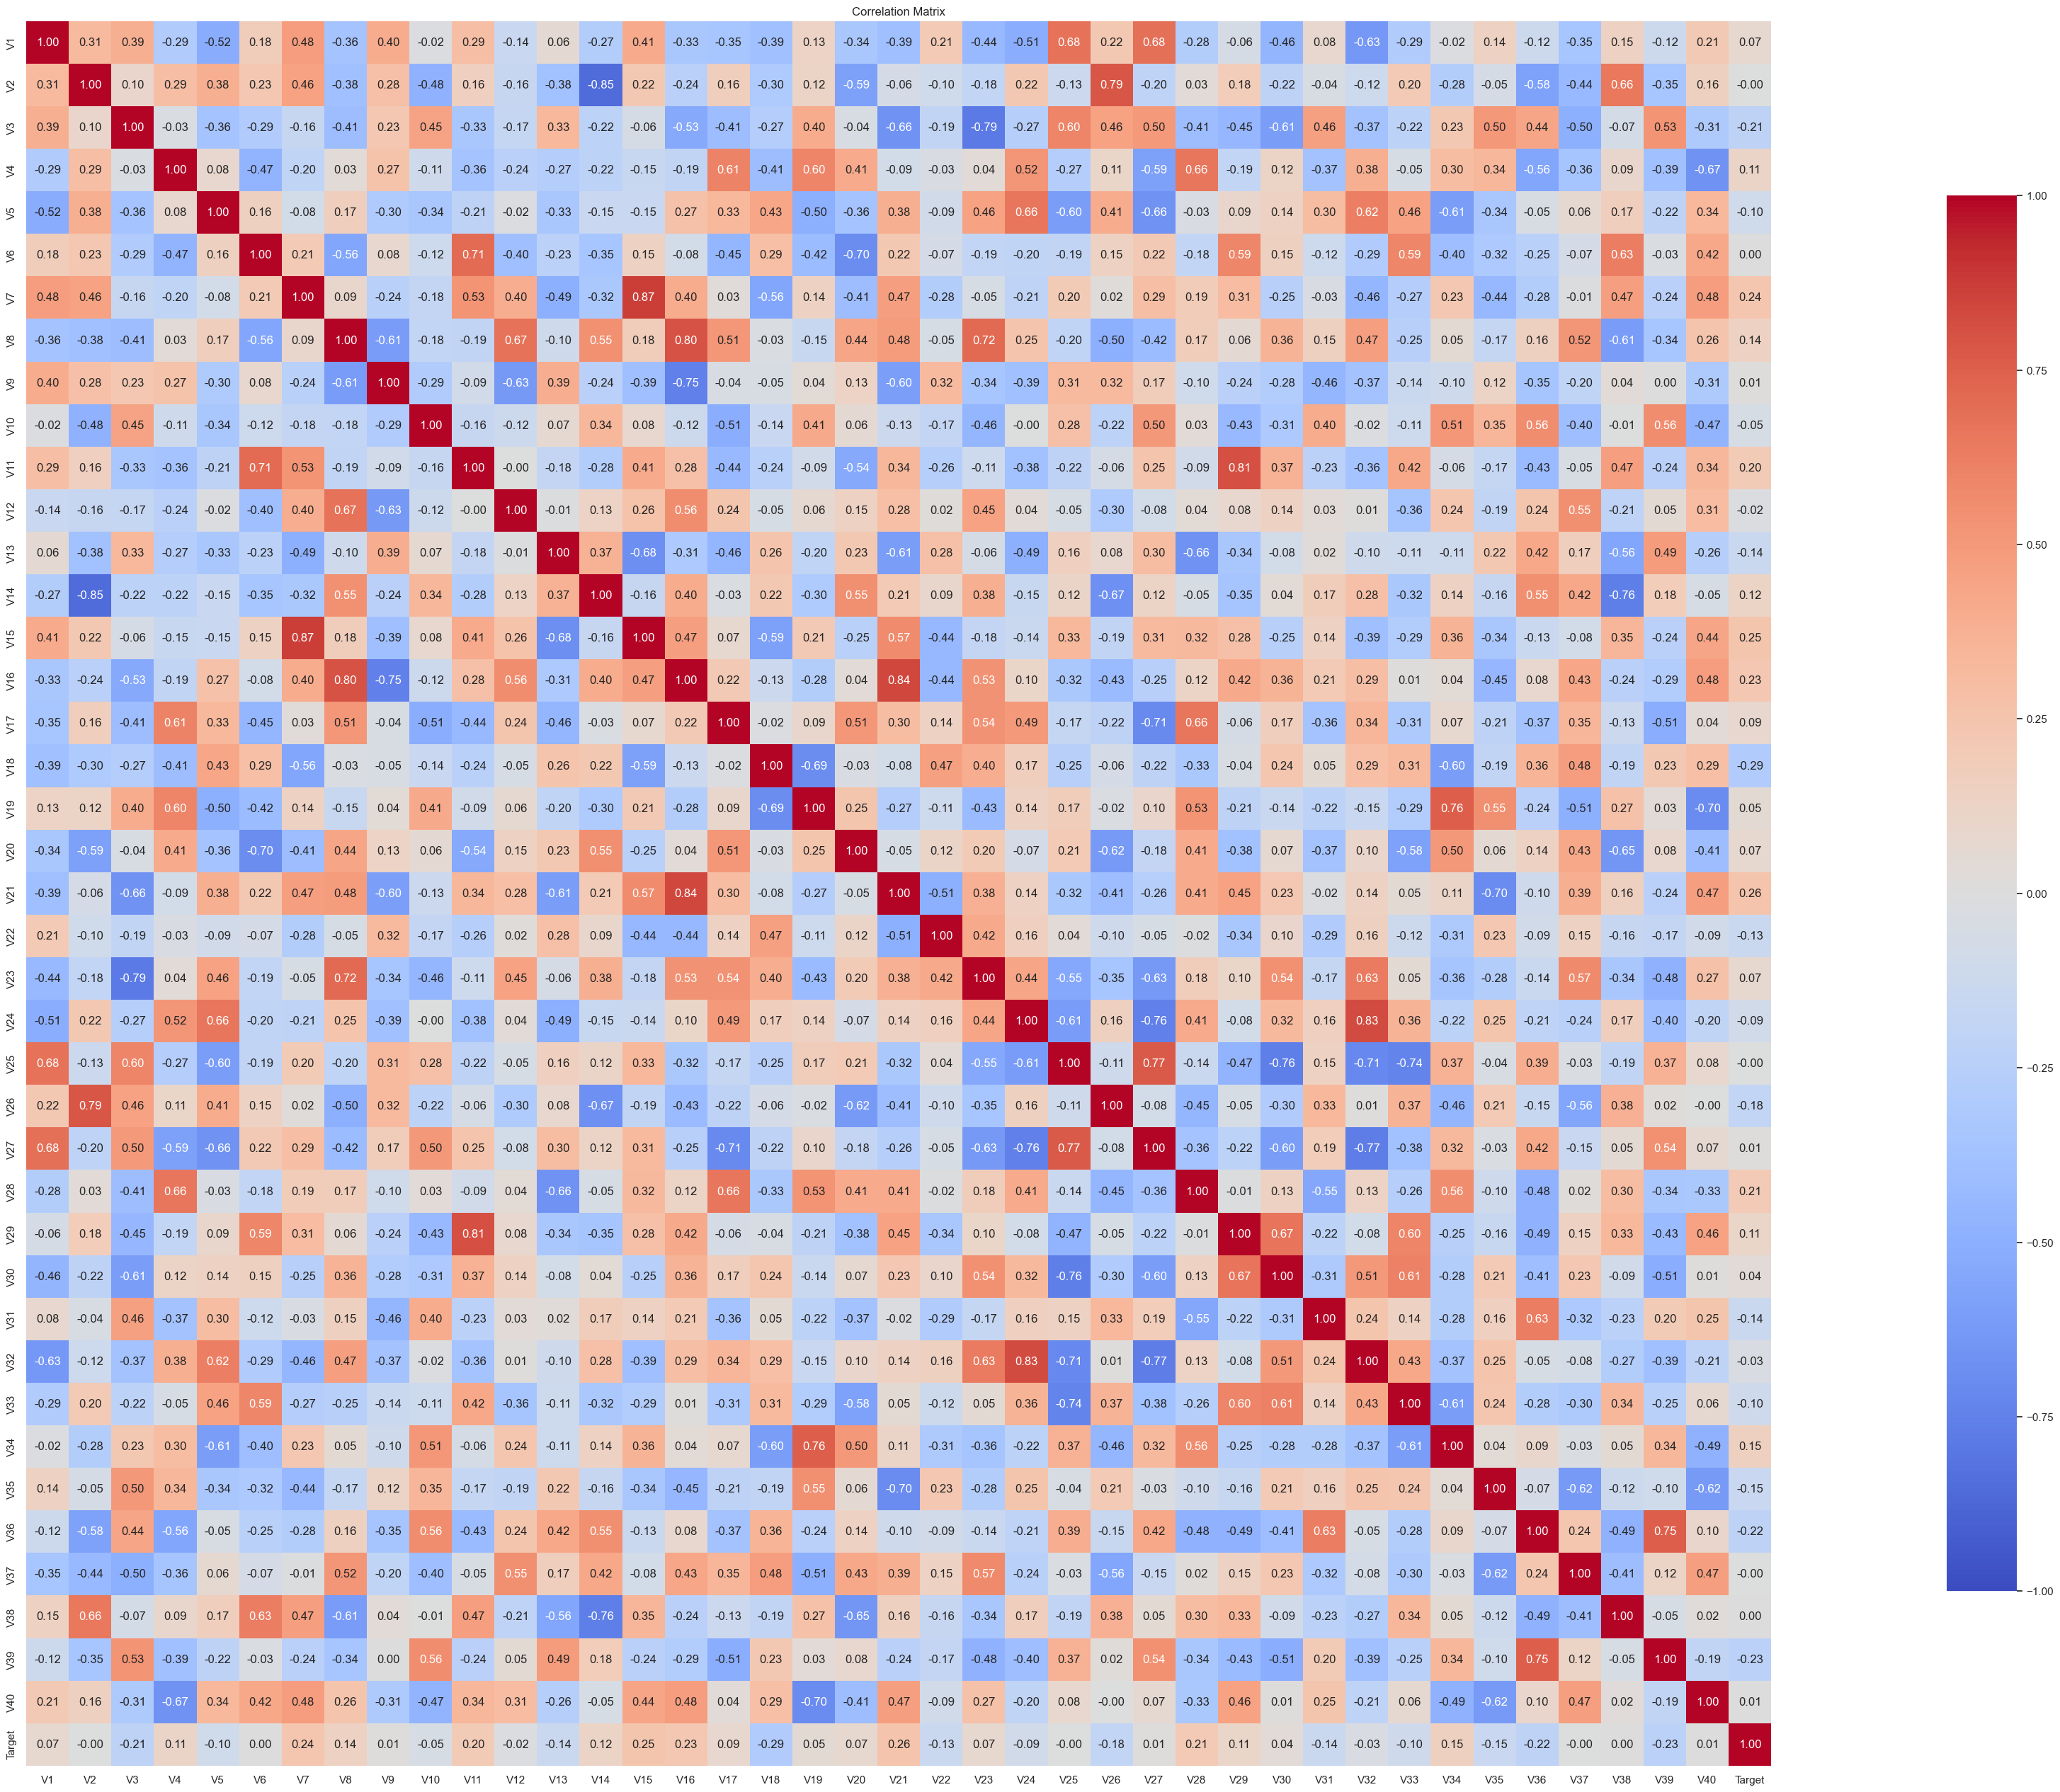

Strong Correlations:
     Variable1 Variable2 Correlation
3          V1        V5        True
22         V1       V24        True
23         V1       V25        True
25         V1       V27        True
30         V1       V32        True
51         V2       V14        True
57         V2       V20        True
63         V2       V26        True
73         V2       V36        True
75         V2       V38        True
91         V3       V16        True
96         V3       V21        True
98         V3       V23        True
100        V3       V25        True
105        V3       V30        True
110        V3       V35        True
112        V3       V37        True
114        V3       V39        True
129        V4       V17        True
131        V4       V19        True
136        V4       V24        True
139        V4       V27        True
140        V4       V28        True
148        V4       V36        True
152        V4       V40        True
167        V5       V19        True
172   

In [14]:
draw_default_correlation_matrix(train_data_copy)

#Identify all the variables that have strong correlations with each other
# Note: The threshold for strong correlation is set to 0.5
strong_correlations = train_data_copy.corr().abs() > THRESHOLD
strong_correlations = strong_correlations.where(np.triu(np.ones(strong_correlations.shape), k=1).astype(bool))
strong_correlations = strong_correlations.stack().reset_index()
strong_correlations.columns = ['Variable1', 'Variable2', 'Correlation']
strong_correlations = strong_correlations[strong_correlations['Correlation'] == True]

print("Strong Correlations:\n", strong_correlations)

* There are 40 input variables that all have complex interactions between the output variable, but there is no strong positive or negative correlation between any of the input variables and Target for the output variable.
* The variables that have strong correlations (positive or negative) are listed above.
* Since there are many variables with no clear correlation or strong correlation with the output variable this will be the extent of the bi-variate analysis as going further will add no additional insight.


# **Data Preprocessing**

### Train Validation Split

In [15]:
# defining the dependent and independent variables
X = train_data_copy.drop(["Target"], axis=1)
y = train_data_copy["Target"]

# Splitting the data into training and validation sets. We need to use stratify to maintain the same distribution of the target variable in both sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VS,random_state=RS, stratify=y, shuffle=True)

X_test = test_data_copy.drop(["Target"], axis=1)
y_test = test_data_copy["Target"]

# Check that the percentage of the output variable is the same in both train and validation datasets
train_percentage = y_train.value_counts(normalize=True)
val_percentage = y_val.value_counts(normalize=True)

print("Train Data Output Percentage:\n\n", train_percentage)
print("Validation Data Output Percentage:\n", val_percentage)

# Print the shape of the training and validation sets
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)

Train Data Output Percentage:

 Target
0    0.944467
1    0.055533
Name: proportion, dtype: float64
Validation Data Output Percentage:
 Target
0    0.9446
1    0.0554
Name: proportion, dtype: float64
Training Data Shape: (15000, 40) (15000,)
Validation Data Shape: (5000, 40) (5000,)


### Initial Data Set Treatment ###

In [16]:
#Convert Target variable to an Float64 on the training, validation, and test sets to be 100% consistent
y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test = y_test.astype(float)

# Impute the missing values in the training, validation, and test sets using the median of each column.
# The median is used to avoid the influence of outliers. We use SimpleImputer to systematically handle missing values across multiple columns in a dataset.
imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

#Confirm that there are no missing values in the training, validation, and test sets
print("Missing Values in Training Set:", X_train.isnull().sum().sum())
print("Missing Values in Validation Set:", X_val.isnull().sum().sum())
print("Missing Values in Test Set:", X_test.isnull().sum().sum())

Missing Values in Training Set: 0
Missing Values in Validation Set: 0
Missing Values in Test Set: 0


# **Model Building**

### Model Evaluation Metrics and Plotting Functions

* To save and reduce code duplication I'm predefining methods that will be used frequently in thd data Modeling steps. The methods will cover:
    * Performance metric calculations
    * Model performance plots
    

In [17]:
# Method to calculate difference in performance metrics between two model lists
# Parameters:
# model_training_metrics_list (list): First list of models to compare.
# model_validation_metrics_list (list): Second list of models to compare.
# Returns:
# A DataFrame containing the difference in performance metrics between the two model lists.
def performance_metrics_difference(model_training_metrics_list, model_validation_metrics_list):
     #Initialize empty DataFrame to store the difference in performance metrics
    all_differences_df = pd.DataFrame()
    
    #Loop through model_training_metrics_list and model_validation_metrics_list indices and calculate the difference in performance metrics
    for index in range(len(model_training_metrics_list)):
        model_training_metrics_df = model_training_metrics_list.iloc[index]
        model_validation_metrics_df = model_validation_metrics_list.iloc[index]
        
        # Calculate the absolute difference in performance metrics
        difference_df = pd.DataFrame({
            'Model': "Model " + str(index),
            'Loss Difference': abs(model_training_metrics_df['Loss'] - model_validation_metrics_df['Loss']),
            'F1 Score Difference': abs(model_training_metrics_df['F1 Score'] - model_validation_metrics_df['F1 Score']),
            'Accuracy Score Difference': abs(model_training_metrics_df['Accuracy Score'] - model_validation_metrics_df['Accuracy Score']),
            'Recall Score Difference': abs(model_training_metrics_df['Recall Score'] - model_validation_metrics_df['Recall Score']),
            'Precision Score Difference': abs(model_training_metrics_df['Precision Score'] - model_validation_metrics_df['Precision Score'])
        }, index=[0])

        # Append the difference DataFrame to the all_differences_df
        all_differences_df = pd.concat([all_differences_df, difference_df], ignore_index=True)

    # Return the DataFrame containing the differences in performance metrics
    return all_differences_df

def plot_loss_accuracy(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

In [18]:
from sklearn.utils import class_weight

# Function to calculate performance metrics of a model
# Parameters:
# model: The trained model to evaluate.
# X: Features used for prediction.
# y: True labels for the features.
# model_name: Name of the model for identification in the output DataFrame.
# Returns:
# A DataFrame containing the performance metrics of the model, including F1 score, accuracy, recall, and precision.
def performance_metrics(model, X, y, model_name="Default"):
    y_pred = model.predict(X) > THRESHOLD

    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision  = precision_score(y, y_pred)

    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'F1 Score': [f1],
        'Accuracy Score': [accuracy],
        'Recall Score': [recall],
        'Precision Score': [precision]
    })

    return metrics_df

def get_binary_prediction_value(y_pred):
    return (y_pred > THRESHOLD).astype(int).flatten()

def evaluate_neural_network_on_recall(
      model,
      x,
      y,
      validation_data,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      model_name="Default",
      plot_loss_graph=False
):
    # Always Build the model against the specified training data and use the epochs, batch_size, and validation data passed into this function.
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size = batch_size,
                        validation_data=validation_data,
                        class_weight = CLASS_WEIGHTS,                
                        verbose=0)

    if plot_loss_graph:
        plot_loss_accuracy(history, 'loss')

    y_pred = get_binary_prediction_value(model.predict(x))

    # Calculate the loss and recall of the model
    loss, recall = model.evaluate(x, y, verbose=0)

    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision  = precision_score(y, y_pred)

    # To make things cleaner create a DataFrame out of the classification report as a dictionary
    report = classification_report(y, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Add a caption/title using Styler
    styled_report_df = report_df.style.set_caption(model_name + " Classification Report")
    
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'Loss': [loss],
        'F1 Score': [f1],
        'Accuracy Score': [accuracy],
        'Recall Score': [recall],
        'Precision Score': [precision]
    })
    
    #Return the metrics and report DataFrames
    return metrics_df, styled_report_df

def generate_model_reports(model, model_name="Default"):
    # clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
    tf.keras.backend.clear_session()

    model_training_metrics_df, model_training_report_df  = evaluate_neural_network_on_recall(
        model = model,
        x = X_train,
        y = y_train,
        validation_data=(X_val, y_val),
        model_name=model_name + " Training",
        plot_loss_graph=True
    )

    model_validation_metrics_df, model_validation_report_df = evaluate_neural_network_on_recall(
        model = model,
        x = X_val,
        y = y_val,
        validation_data=(X_val, y_val),
        model_name= model_name + " Validation",
    )

    model.summary()

    display(model_training_metrics_df)
    display(model_validation_metrics_df)

    display(model_training_report_df)
    display(model_validation_report_df)
    
    return model_training_metrics_df, model_validation_metrics_df, model_training_report_df, model_validation_report_df   

## Model Evaluation Criterion

* Since the largest expense to the company is misclassifying failures that would result in the most cost replacement fee, the model should focus on maximizing detection of actual failures (True Positives). As a result the performance metric that the model will focus on is recall.

## Initial Model Building (Model 0)

- Let's start with a neural network consisting of
  - just one hidden layer
  - activation function of ReLU
  - SGD as the optimizer

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 843 (3.30 KB)

 Trainable params: 841 (3.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model    Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 0 Training  0.0908  0.846585        0.981733      0.907563   

   Precision Score  
0         0.793284

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 0 Validation  0.111384  0.787402           0.973      0.902527   

   Precision Score  
0         0.698324

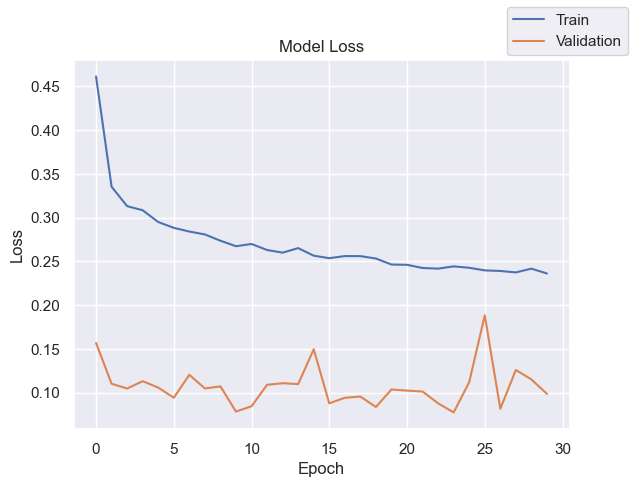

In [19]:
# Define the optimizer to be used for training the model
# Using SGD (Stochastic Gradient Descent) optimizer with default parameters
# Note: You can also use other optimizers like Adam, RMSprop, etc. based on your requirements.
optimizer = keras.optimizers.SGD()

model0 = Sequential()
model0.add(Dense(20, activation='relu', input_dim=X_train.shape[1]))
# Sigmoid output layer for binary classification
model0.add(Dense(1, activation='sigmoid'))  
model0.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['Recall'])

# Generate the model reports
model0_training_metrics_df, model0_validation_metrics_df, model0_training_report_df, model0_validation_report_df = generate_model_reports(
    model=model0,
    model_name="Model 0"
)

* On the initial model setup we achieve a recall score of .884 and .909 on the training and validation sets respectively which is a good start.
* The model is not overfit at this point.

# **Model Performance Improvement**

## Model 1


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,483 (9.70 KB)

 Trainable params: 2,481 (9.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 1 Training  0.038931  0.936937           0.993      0.936375   

   Precision Score  
0           0.9375

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 1 Validation  0.119307  0.797428          0.9748      0.895307   

   Precision Score  
0         0.718841

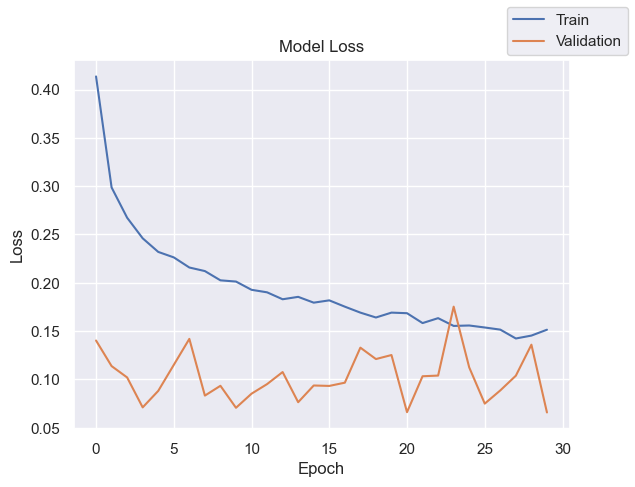

In [20]:
# Define the optimizer to be used for training the model
# Using SGD (Stochastic Gradient Descent) optimizer with default parameters
# Note: You can also use other optimizers like Adam, RMSprop, etc. based on your requirements.
optimizer = keras.optimizers.SGD()

# Define a more complex model with additional layers
# This model has two hidden layers with 40 and 20 neurons respectively, using ReLU activation functions.
# The output layer uses a sigmoid activation function for binary classification.
model1 = Sequential()
model1.add(Dense(40, activation='relu', input_dim=X_train.shape[1]))
model1.add(Dense(20, activation='relu'))
# Sigmoid output layer for binary classification
model1.add(Dense(1, activation='sigmoid'))  
model1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['Recall'])

# Generate the model reports
model1_training_metrics_df, model1_validation_metrics_df, model1_training_report_df, model1_validation_report_df = generate_model_reports(
    model=model1,
    model_name="Model 1"
)


* The model achieves a recall score of .943 and .898 on the training and validation sets respectively which is a marginal improvement only on the training set when adding an additional hidden layer.
* The model is not overfit at this point.
* The loss values converge at around 13 and 15 epochs.

## Model 2

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,683 (10.48 KB)

 Trainable params: 2,681 (10.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 2 Training  0.069391  0.882751        0.986133      0.939976   

   Precision Score  
0         0.832094

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 2 Validation  0.090182  0.847059          0.9818      0.909747   

   Precision Score  
0         0.792453

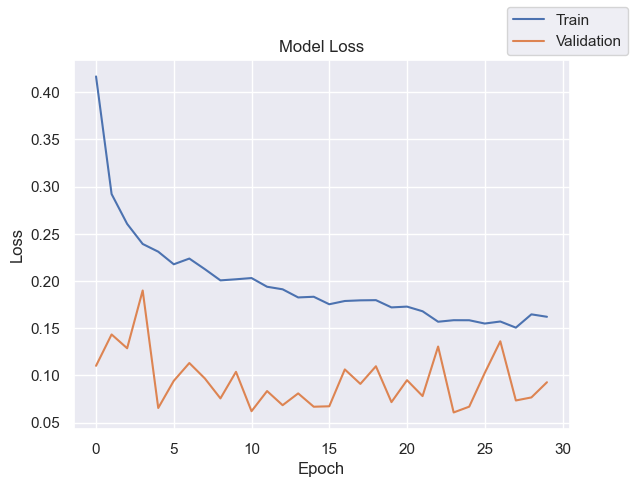

In [21]:
# Define the optimizer to be used for training the model
# Using SGD (Stochastic Gradient Descent) optimizer with default parameters
# Note: You can also use other optimizers like Adam, RMSprop, etc. based on your requirements.
optimizer = keras.optimizers.SGD()

# Define a more complex model with additional layers
# This model has three hidden layers with 40, 20, and 10 neurons respectively, using ReLU activation functions.
# The output layer uses a sigmoid activation function for binary classification.
model2 = Sequential()
model2.add(Dense(40, activation='relu', input_dim=X_train.shape[1]))
model2.add(Dense(20, activation='relu'))
model2.add(Dense(10, activation='relu'))
# Sigmoid output layer for binary classification
model2.add(Dense(1, activation='sigmoid'))  
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['Recall'])

# Generate the model reports
model2_training_metrics_df, model2_validation_metrics_df, model2_training_report_df, model2_validation_report_df = generate_model_reports(
    model=model2,
    model_name="Model 2"
)

* The model achieves a recall score of .935 and .891 on the training and validation sets respectively. The training set performs about the same and the validation set performs about the same as the previous model.
* The model is not overfit at this point and the training and validation recall scores are also very close to each other. Adding the additional model complexity with the addition of a 3rd layer doesn't really improve the performance.


## Model 3

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,045 (31.43 KB)

 Trainable params: 2,681 (10.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,364 (20.96 KB)

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 3 Training  0.048698  0.934211        0.992667      0.937575   

   Precision Score  
0          0.93087

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 3 Validation  0.107645  0.856164          0.9832      0.902527   

   Precision Score  
0         0.814332

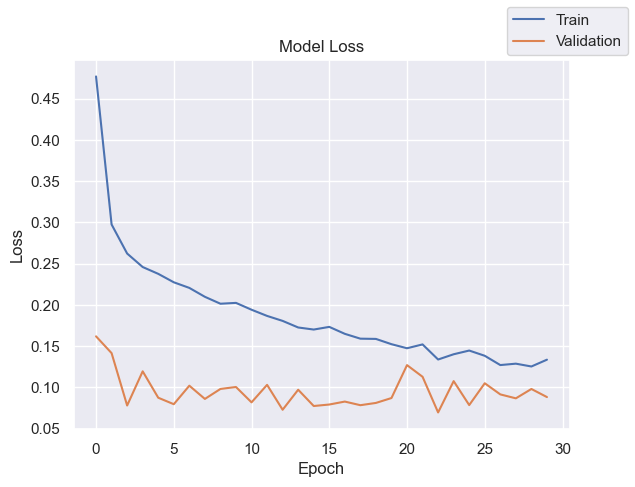

In [22]:
# Define the optimizer to be used for training the model
# Using Adam optimizer with a specified learning rate
# Note: You can also use other optimizers like SGD, RMSprop, etc. based on your requirements.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define a more complex model with additional layers
# This model has three hidden layers with 40, 20, and 10 neurons respectively, using ReLU activation functions.
# The output layer uses a sigmoid activation function for binary classification.
model3 = Sequential()
model3.add(Dense(40, activation='relu', input_dim=X_train.shape[1]))
model3.add(Dense(20, activation='relu'))
model3.add(Dense(10, activation='relu'))
# Sigmoid output layer for binary classification
model3.add(Dense(1, activation='sigmoid'))  
model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['Recall'])

# Generate the model reports
model3_training_metrics_df, model3_validation_metrics_df, model3_training_report_df, model3_validation_report_df = generate_model_reports(
    model=model3,
    model_name="Model 3"
)

* The model achieves a recall score of .951 and .906 on the training and validation sets respectively. The training set performs better and the validation set performs better than the previous model.
* Adding the additional model complexity with the addition of a 3rd layer improves the performance slightly.

## Model 4

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,205 (32.05 KB)

 Trainable params: 2,721 (10.63 KB)

 Non-trainable params: 40 (160.00 B)

 Optimizer params: 5,444 (21.27 KB)

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 4 Training  0.050145  0.925391        0.991733      0.923169   

   Precision Score  
0         0.927624

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 4 Validation  0.075911  0.870466           0.985      0.909747   

   Precision Score  
0         0.834437

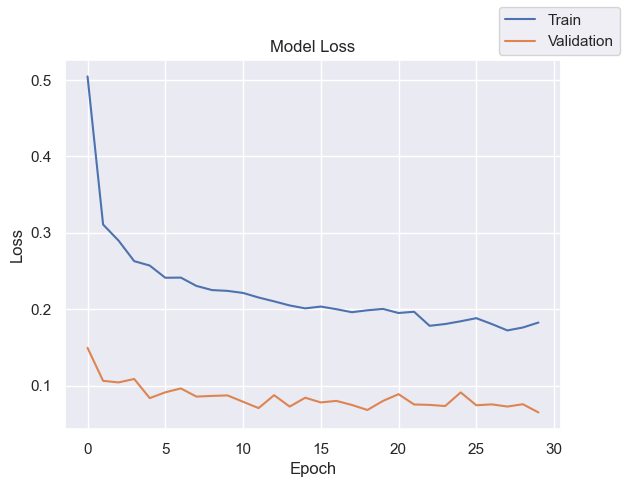

In [23]:
# Define the optimizer to be used for training the model
# Using Adam optimizer with a specified learning rate
# Note: You can also use other optimizers like SGD, RMSprop, etc. based on your requirements.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define a more complex model with additional layers
# This model has three hidden layers with 40, 20, and 10 neurons respectively, using ReLU activation functions.
# The second layer has a batch normalization layer added to improve training stability and performance.
# The output layer uses a sigmoid activation function for binary classification.
model4 = Sequential()
model4.add(Dense(40, activation='relu', input_dim=X_train.shape[1]))
model4.add(Dense(20, activation='relu'))
 #Add batch normalization layer after the 2nd layer
model4.add(BatchNormalization())
model4.add(Dense(10, activation='relu'))
# Sigmoid output layer for binary classification
model4.add(Dense(1, activation='sigmoid'))  
model4.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['Recall'])

# Generate the model reports
model4_training_metrics_df, model4_validation_metrics_df, model4_training_report_df, model4_validation_report_df = generate_model_reports(
    model=model4,
    model_name="Model 4"
)

* The model achieves a recall score of .923 and .909 on the training and validation sets respectively. The training set and validation set performs slightly worse than the previous model.
* Adding the additional model complexity with the addition of a 3rd layer and Batch Normalization does not help as much to improve performance on the model overall.

## Model 5

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,125 (31.74 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 5,404 (21.11 KB)

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 5 Training  0.068797   0.91432        0.990467      0.915966   

   Precision Score  
0         0.912679

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 5 Validation  0.098513  0.918033           0.991      0.909747   

   Precision Score  
0         0.926471

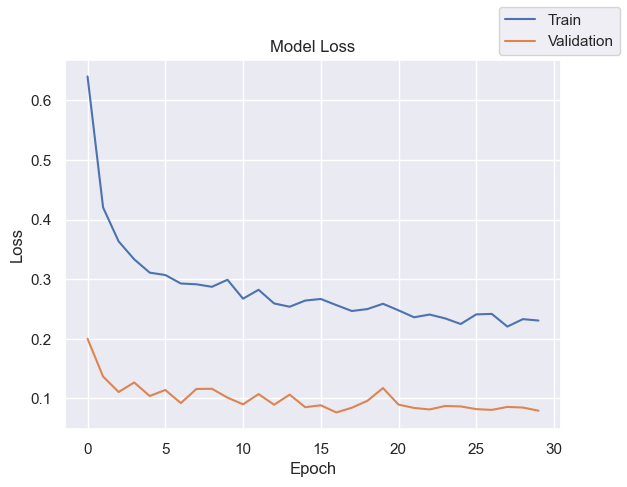

In [24]:
# Define the optimizer to be used for training the model
# Using Adam optimizer with a specified learning rate
# Note: You can also use other optimizers like SGD, RMSprop, etc. based on your requirements.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define a more complex model with additional layers
# This model has three hidden layers with 40, 20, and 10 neurons respectively, using ReLU activation functions.
# The second layer has a dropout layer added to prevent overfitting.
# The third layer has a batch normalization layer added to improve training stability and performance.
# The output layer uses a sigmoid activation function for binary classification.
# Note: The dropout rate is set to 0.3, which means 30% of the neurons will be randomly dropped during training.
model5 = Sequential()
model5.add(Dense(40, activation='relu', input_dim=X_train.shape[1]))
model5.add(Dense(20, activation='relu'))
# Add dropout layer after the 2nd layer to prevent overfitting
model5.add(Dropout(0.3))
model5.add(Dense(10, activation='relu'))
 #Add batch normalization layer after the 3rd layer
model5.add(BatchNormalization())
# Sigmoid output layer for binary classification
model5.add(Dense(1, activation='sigmoid'))  
model5.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['Recall'])

# Generate the model reports
model5_training_metrics_df, model5_validation_metrics_df, model5_training_report_df, model5_validation_report_df = generate_model_reports(
    model=model5,
    model_name="Model 5"
)

* The model achieves a recall score of .913 and .909 on the training and validation sets respectively. The training set and validation set both perform about the same as the previous model and maybe slightly worse.

## Model 6

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,275 (32.33 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 5,504 (21.50 KB)

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 6 Training  0.079933  0.919374        0.991067      0.917167   

   Precision Score  
0         0.921592

Model      Loss  F1 Score  Accuracy Score  Recall Score  \
0  Model 6 Validation  0.073594  0.904505          0.9894      0.906137   

   Precision Score  
0         0.902878

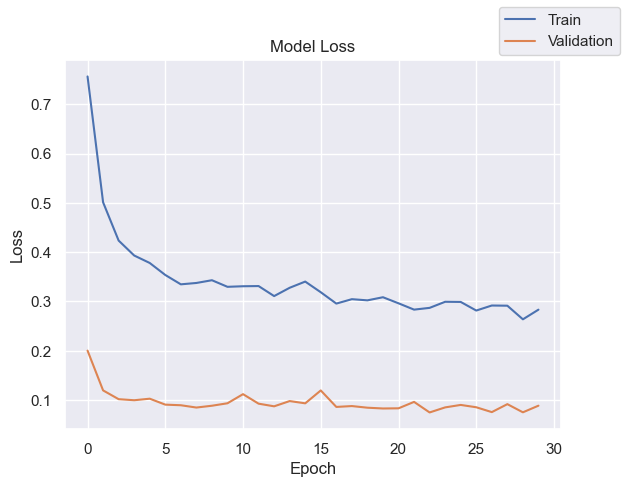

In [25]:
# Define the optimizer to be used for training the model
# Using Adam optimizer with a specified learning rate
# Note: You can also use other optimizers like SGD, RMSprop, etc. based on your requirements.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define a more complex model with additional layers
# This model has four hidden layers with 40, 20, 10, and 5 neurons respectively, using ReLU activation functions.
# The second and fourth layers have dropout layers added to prevent overfitting.
# The third layer has a batch normalization layer added to improve training stability and performance.
# The output layer uses a sigmoid activation function for binary classification.
# Note: The dropout rate is set to 0.3, which means 30% of the neurons will be randomly dropped during training.
model6 = Sequential()
model6.add(Dense(40, activation='relu', input_dim=X_train.shape[1]))
model6.add(Dense(20, activation='relu'))
# Add dropout layer after the 2nd layer to prevent overfitting
model6.add(Dropout(0.3))
model6.add(Dense(10, activation='relu'))
 #Add batch normalization layer after the 3rd layer
model6.add(BatchNormalization())
model6.add(Dense(5, activation='relu'))
# Add dropout layer after the 4th layer to prevent overfitting
model6.add(Dropout(0.3))
# Sigmoid output layer for binary classification
model6.add(Dense(1, activation='sigmoid'))
model6.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['Recall'])

# Generate the model reports
model6_training_metrics_df, model6_validation_metrics_df, model6_training_report_df, model6_validation_report_df = generate_model_reports(
    model=model6,
    model_name="Model 6"
)

* The model achieves a recall score of .914 and .909 on the training and validation sets respectively. The training set and validation both perform about the same as the previous model.
* Adding the additional drop out layers, additional hidden layers, and normalization layers is making the model overly complex without adding any value.

# **Model Performance Comparison and Final Model Selection**

Now, in order to select the final model, we will compare the performances of all the models for the training and validation sets.

In [26]:
# Collect all of the training model metrics DataFrames into a single DataFrame
model_training_metrics_list = pd.concat([
    model0_training_metrics_df,
    model1_training_metrics_df,
    model2_training_metrics_df,
    model3_training_metrics_df,
    model4_training_metrics_df,
    model5_training_metrics_df,
    model6_training_metrics_df
], ignore_index=True)

# Collect all of the validation model metrics DataFrames into a single DataFrame
model_validation_metrics_list = pd.concat([
    model0_validation_metrics_df,
    model1_validation_metrics_df,
    model2_validation_metrics_df,
    model3_validation_metrics_df,
    model4_validation_metrics_df,
    model5_validation_metrics_df,
    model6_validation_metrics_df
], ignore_index=True)

#Calculate the difference in performance metrics between the training and validation model metrics DataFrames
model_metrics_difference_df = performance_metrics_difference(
    model_training_metrics_list,
    model_validation_metrics_list
)

#Sort the model metrics difference DataFrame by the Recall Score Difference in ascending order
model_metrics_difference_df = model_metrics_difference_df.sort_values(by='Recall Score Difference')

display(model_training_metrics_list.T)
display(model_validation_metrics_list.T)
display(model_metrics_difference_df.T)

#Print the best model based on the validation recall score and that has the smallest difference in recall score between the training and validation sets
display(model_metrics_difference_df.iloc[0].T)

0                 1                 2  \
Model            Model 0 Training  Model 1 Training  Model 2 Training   
Loss                       0.0908          0.038931          0.069391   
F1 Score                 0.846585          0.936937          0.882751   
Accuracy Score           0.981733             0.993          0.986133   
Recall Score             0.907563          0.936375          0.939976   
Precision Score          0.793284            0.9375          0.832094   

                                3                 4                 5  \
Model            Model 3 Training  Model 4 Training  Model 5 Training   
Loss                     0.048698          0.050145          0.068797   
F1 Score                 0.934211          0.925391           0.91432   
Accuracy Score           0.992667          0.991733          0.990467   
Recall Score             0.937575          0.923169          0.915966   
Precision Score           0.93087          0.927624          0.912679   

                                6  
Model            Model 6 Training  
Loss                     0.079933  
F1 Score                 0.919374  
Accuracy Score           0.991067  
Recall Score             0.917167  
Precision Score          0.921592

0                   1                   2  \
Model            Model 0 Validation  Model 1 Validation  Model 2 Validation   
Loss                       0.111384            0.119307            0.090182   
F1 Score                   0.787402            0.797428            0.847059   
Accuracy Score                0.973              0.9748              0.9818   
Recall Score               0.902527            0.895307            0.909747   
Precision Score            0.698324            0.718841            0.792453   

                                  3                   4                   5  \
Model            Model 3 Validation  Model 4 Validation  Model 5 Validation   
Loss                       0.107645            0.075911            0.098513   
F1 Score                   0.856164            0.870466            0.918033   
Accuracy Score               0.9832               0.985               0.991   
Recall Score               0.902527            0.909747            0.909747   
Precision Score            0.814332            0.834437            0.926471   

                                  6  
Model            Model 6 Validation  
Loss                       0.073594  
F1 Score                   0.904505  
Accuracy Score               0.9894  
Recall Score               0.906137  
Precision Score            0.902878

0         5         6         4         2  \
Model                        Model 0   Model 5   Model 6   Model 4   Model 2   
Loss Difference             0.020584  0.029716  0.006339  0.025766   0.02079   
F1 Score Difference         0.059183  0.003713   0.01487  0.054925  0.035692   
Accuracy Score Difference   0.008733  0.000533  0.001667  0.006733  0.004333   
Recall Score Difference     0.005036  0.006219   0.01103  0.013422  0.030229   
Precision Score Difference   0.09496  0.013791  0.018715  0.093187  0.039641   

                                   3         1  
Model                        Model 3   Model 1  
Loss Difference             0.058947  0.080376  
F1 Score Difference         0.078046  0.139509  
Accuracy Score Difference   0.009467    0.0182  
Recall Score Difference     0.035048  0.041068  
Precision Score Difference  0.116538  0.218659

Model                          Model 0
Loss Difference               0.020584
F1 Score Difference           0.059183
Accuracy Score Difference     0.008733
Recall Score Difference       0.005036
Precision Score Difference     0.09496
Name: 0, dtype: object

* After calculating the differences between the training and validation sets across the recall score, model #0 had the least difference between the training and validation set. So this will be the model that we will evaluate against our testing set.

Now, let's check the performance of the final model on the test set.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


Model  F1 Score  Accuracy Score  Recall Score  Precision Score
0  Model 0 Test  0.767802            0.97      0.879433         0.681319

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


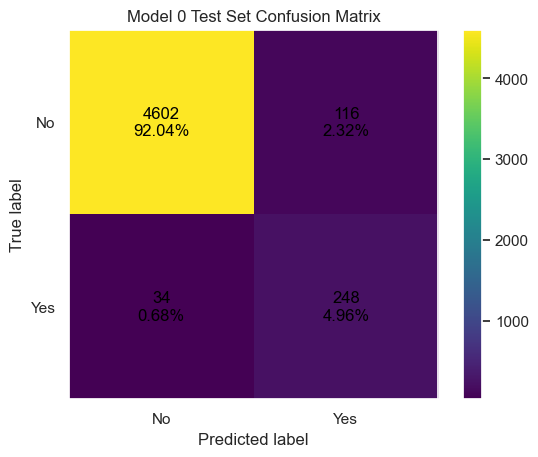

In [30]:
# Calculate the performance metrics of the best model on the test set
best_model_test_perf = performance_metrics(model0,X_test,y_test,"Model 0 Test")

y_test_pred_best = model0.predict(X_test)

 # To make things cleaner create a DataFrame out of the classification report as a dictionary
report = classification_report(y_test, y_test_pred_best>THRESHOLD, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Add a caption/title using Styler
styled_report_df = report_df.style.set_caption("Model 0 Test Set Classification Report")

display(best_model_test_perf)
display(styled_report_df)
draw_confusion_matrix(model0, X_test, y_test, "Model 0 Test Set Confusion Matrix")

# **Actionable Insights and Recommendations**

* The model is able to accurately detect ~87% of the wind turbines that are about to fail. Based on the confusion matrix, it correctly predicts the failures of 248 out of 282 of the actual failures. 
* As stated previously the primary metric that the modeling focused on was recall since the biggest financial risk to the company is the wind turbine replacement cost. So staying ahead of this is a safer bet.
* In the worst case scenario if the model classifies a wind turbines as about to fail but doesn't, it costs the company the least amount of money because it only requires an inspection fee vs a replacement fee.
* Since the input parameters are redacted for security reasons, the best that we were able to do was to indicate based on the bi-variate analysis which input parameters were highly correlated to each other. However, there was no high correlation of any of the input values on the Target output at all. The business will know best on what those exact parameters are.
* While the neural network model does a great job of capturing complex interactions between the 40 input parameters, this same ability to adapt towards complexity does not grant us the ability to describe feature(input) importance as we can do with other types of machine learning algorithms.
* One of the major challenges with the data set is that it was heavily skewed towards non-failures, so this definitely contributed to keeping the model prediction within the high 80th percentile range of true failure detection. If possible, it would be helpful to gather more failure scenarios in the data set and to be able to have a more balanced data set in general for the model to learn from. Other things that we could try in the future would be to use techniques such as SMOTE to synthetically create failure scenarios to fill out the data set.
* Lastly, it would be helpful to understand from the business based on this first generation model if there is an ideal target prediction performance that the business would like the model to achieve.

### Export the project to HTML

In [34]:
# Export the project to HTML

!jupyter nbconvert --to html "ErnestHolloway-INN_ReneWind_Main_Project_FullCode_Notebook-8-4-25.ipynb"

[NbConvertApp] Converting notebook ErnestHolloway-INN_ReneWind_Main_Project_FullCode_Notebook-8-4-25.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 50 image(s).
[NbConvertApp] Writing 4976157 bytes to ErnestHolloway-INN_ReneWind_Main_Project_FullCode_Notebook-8-4-25.html
